# Demo of the GTM on 10-Dimensional R-Vine-Copula Data

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 10 dimensional R-Vine-Copula as done in our [Paper](https://arxiv.org/pdf/2503.17845) Section 4.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [1]:
from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv
# Helpers to generate specfific vines and analyze there conditional independencies
from pyvinecopulib_simulation_helpers import *

# Other Stuff
import numpy as np
import torch
import torch
from torch.utils.data import DataLoader
from dataset_helpers import Generic_Dataset
from sklearn.metrics import roc_auc_score, roc_curve

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
set_seeds(1)

### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a R-Vine-Copula and add Gaussian marginals. To create the Vine we use the functions `sample_random_pair_copulas`and `compute_conditional_dependence_table` from our helpers. Theses allow use to set independence copulas upon Tree 3 to add full conditional independencies as detailed in our Paper. The `df`contains a tables with the copulas, there parameters and there tree positions in a manner comparable to the conditional independence table later generated with the GTM.

In [3]:
D = 8  # dimension
rvine_structure = pv.RVineStructure.simulate(D)
pair_copulas = sample_random_pair_copulas(D,Independence_tree=3)
vine_model = pv.Vinecop.from_structure(structure=rvine_structure, pair_copulas=pair_copulas)
df = compute_conditional_dependence_table(vine_model)
#df

creating a table to compare the true dependence structure later on to what the gtm learned

In [4]:

df_true_structure = df[["tree","edge","conditioned variables", "conditioned variable 1", "conditioned variable 2", "dependence", "var_row", "var_col"]]
df_true_structure_sub = df_true_structure[["var_row", "var_col", "dependence"]]
df_true_structure_sub.loc[:, "var_row"] = df_true_structure_sub["var_row"] - 1
df_true_structure_sub.loc[:, "var_col"] = df_true_structure_sub["var_col"] - 1

The `pyvinecopulib`package offers to plot the tree structures:

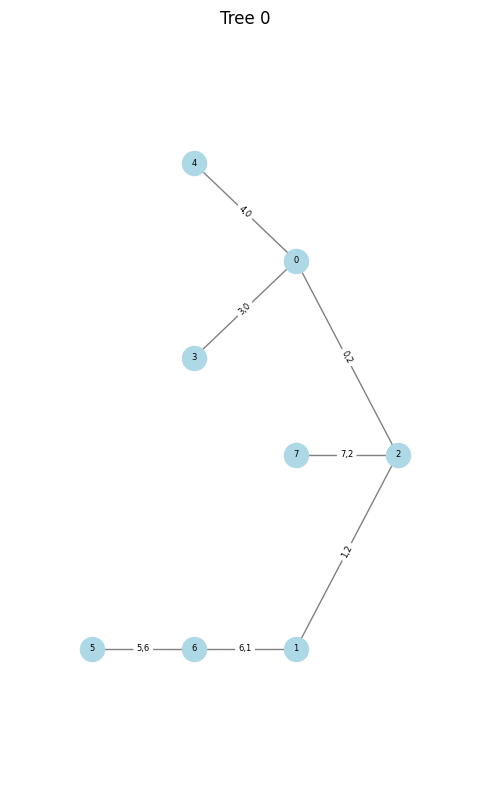

In [5]:
vine_model.plot(tree=[0])

In [6]:
# Train
N_train = 2000
simulated_data_uniform_train = vine_model.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = vine_model.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = vine_model.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [7]:
loglik_copula = np.log(vine_model.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(simulated_data_train).sum(1)
loglik_true_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(vine_model.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(simulated_data_validate).sum(1)
loglik_true_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(vine_model.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(simulated_data_test).sum(1)
loglik_true_test = torch.tensor(loglik_copula) + log_marginals

We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

In [8]:
copula_pv_est = vine_model
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

In [9]:
loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = torch.tensor(loglik_copula) + log_marginals

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [10]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_train)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_validate)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [11]:
model_freq = GTM(
        number_variables = D,
        number_transformation_layers = 1,
        number_decorrelation_layers= 3,
        degree_transformations = 15,
        degree_decorrelation = 30,
        spline_transformation = "bspline",
        spline_decorrelation = "bspline",
        transformation_spline_range = (-10, 10),
        device = "cuda" if torch.cuda.is_available() else "cpu")

The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

In [12]:
#model_freq.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])

In [13]:
#model_freq.plot_marginals(simulated_data_train)

### 3. Hyperparameter Tune and Train Model

#### 3.1 GTM

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [14]:
study = model_freq.hyperparameter_tune_penalties( 
        train_dataloader = dataloader_train,
        validate_dataloader = dataloader_validate,
        penalty_decorrelation_ridge_param = None,
        penalty_decorrelation_ridge_first_difference = "sample",
        penalty_decorrelation_ridge_second_difference = "sample",
        penalty_transformation_ridge_second_difference = None,
        penalty_lasso_conditional_independence = None,
        adaptive_lasso_weights_matrix=False,
        optimizer="LBFGS",
        learning_rate=1,
        iterations=2000,
        patience=5,
        min_delta=1e-7,
        seperate_copula_training=False,
        max_batches_per_iter=False,
        pretrained_transformation_layer=True,
        n_trials=30,
        temp_folder=".",
        study_name=None)
        

penalty_splines_params=torch.FloatTensor([
                            0, #study.best_params["penalty_decorrelation_ridge_param"],
                            study.best_params["penalty_decorrelation_ridge_first_difference"],
                            study.best_params["penalty_decorrelation_ridge_second_difference"],
                            0 #study.best_params["penalty_transformation_ridge_second_difference"]
                              ])
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence=False

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-12-17 08:50:30,014] A new study created in RDB with name: no-name-305f1c9d-6f5a-492e-91c5-0f08e5a3872e
  0%|          | 0/2000 [00:00<?, ?it/s]/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:620: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  x=input_a_clone.T, t=knots.T, c=params_a.T, p=order, d=derivativ
  0%|          | 1/2000 [00:00<10:17,  3.24it/s]

current_loss: tensor(1.4371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4379688501358032
current_loss: tensor(1.4361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4331, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4362245798110962
current_loss: tensor(1.4331, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4306416511535645
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.5446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<02:03, 16.10it/s]

current_loss_val:  1.424967885017395
current_loss: tensor(1.4236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4227, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.424315333366394
current_loss: tensor(1.4227, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4238086938858032
current_loss: tensor(1.4215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4238141775131226
current_loss: tensor(1.4215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4236702919006348
current_loss: tensor(1.4212, de

  1%|          | 12/2000 [00:00<02:04, 15.91it/s]


current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4247273206710815
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4205, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4246751070022583
current_loss: tensor(1.4205, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4205, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4246487617492676
current_loss: tensor(1.4205, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4204, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4240421056747437
Early Stop at iteration 12 with minimal loss tensor(1.4237, device='cuda:0') and patience 5 and min_delta 1e-07


  0%|          | 1/2000 [00:00<05:43,  5.83it/s]

current_loss: tensor(1.4223, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4119, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3332, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3339682817459106
current_loss: tensor(1.3332, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1937, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1821048259735107
current_loss: tensor(1.1937, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<02:54, 11.45it/s]

current_loss: tensor(1.5871, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1696, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1541951894760132
current_loss: tensor(1.1696, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1572, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.140845537185669
current_loss: tensor(1.1572, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1262, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0991759300231934


  0%|          | 7/2000 [00:00<02:39, 12.52it/s]

current_loss: tensor(1.1262, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1205, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0885764360427856
current_loss: tensor(1.1205, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0787280797958374
current_loss: tensor(1.1080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1052, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0771514177322388


  1%|          | 11/2000 [00:00<02:26, 13.58it/s]

current_loss: tensor(1.1052, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0954, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.072799801826477
current_loss: tensor(1.0954, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0879, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0736889839172363
current_loss: tensor(1.0879, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0805, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0665339231491089


  1%|          | 13/2000 [00:01<02:24, 13.78it/s]

current_loss: tensor(1.0805, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0756, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.061376690864563
current_loss: tensor(1.0756, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0726, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.055485725402832
current_loss: tensor(1.0726, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0652, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.049155831336975


  1%|          | 17/2000 [00:01<02:20, 14.10it/s]

current_loss: tensor(1.0652, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0626, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0472067594528198
current_loss: tensor(1.0626, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0595, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0449340343475342
current_loss: tensor(1.0595, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0419036149978638


  1%|          | 19/2000 [00:01<02:20, 14.10it/s]

current_loss: tensor(1.0546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0399060249328613
current_loss: tensor(1.0526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0376278162002563
current_loss: tensor(1.0502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0331772565841675


  1%|          | 21/2000 [00:01<02:20, 14.12it/s]

current_loss: tensor(1.0455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0286296606063843
current_loss: tensor(1.0410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1035, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0251408815383911
current_loss: tensor(1.0379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0361, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:01<02:24, 13.69it/s]

current_loss_val:  1.023348331451416
current_loss: tensor(1.0361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0106860399246216
current_loss: tensor(1.0237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0176, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0025439262390137
current_loss: tensor(1.0176, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0091, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<02:24, 13.65it/s]

current_loss_val:  0.994791567325592
current_loss: tensor(1.0091, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0053, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9914485216140747
current_loss: tensor(1.0053, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9960, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9832072257995605
current_loss: tensor(0.9960, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9917, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:02<02:22, 13.80it/s]

current_loss_val:  0.9803370833396912
current_loss: tensor(0.9917, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9904, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9789182543754578
current_loss: tensor(0.9904, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9899, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9784854054450989
current_loss: tensor(0.9899, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9891, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:02<02:21, 13.94it/s]

current_loss_val:  0.9781094193458557
current_loss: tensor(0.9891, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9882, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9780020713806152
current_loss: tensor(0.9882, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9874, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9771557450294495
current_loss: tensor(0.9874, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9871, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:02<02:18, 14.20it/s]

current_loss_val:  0.9768251180648804
current_loss: tensor(0.9871, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9864, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9759039878845215
current_loss: tensor(0.9864, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9851, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9745802283287048
current_loss: tensor(0.9851, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9841, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:02<02:19, 14.02it/s]

current_loss_val:  0.9732584953308105
current_loss: tensor(0.9841, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9833, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9723803997039795
current_loss: tensor(0.9833, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9823, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9713222980499268
current_loss: tensor(0.9823, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9811, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 43/2000 [00:03<02:25, 13.41it/s]

current_loss_val:  0.9698861837387085
current_loss: tensor(0.9811, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9811, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9802, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9684800505638123
current_loss: tensor(0.9802, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9791, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9668050408363342
current_loss: tensor(0.9791, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 45/2000 [00:03<02:23, 13.66it/s]

current_loss: tensor(0.9778, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9639086127281189
current_loss: tensor(0.9778, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9740, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9604833126068115
current_loss: tensor(0.9740, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9735, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9599640965461731
current_loss: tensor(0.9735, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 49/2000 [00:03<02:19, 13.96it/s]

current_loss: tensor(0.9718, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.95843505859375
current_loss: tensor(0.9718, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9716, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9582300186157227
current_loss: tensor(0.9716, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9710, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9585217833518982
current_loss: tensor(0.9710, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 51/2000 [00:03<02:32, 12.77it/s]

current_loss: tensor(0.9711, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9706, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9582131505012512
current_loss: tensor(0.9706, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9705, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9698, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9585802555084229
current_loss: tensor(0.9698, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9682, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 53/2000 [00:03<02:34, 12.59it/s]

current_loss_val:  0.9592301249504089
current_loss: tensor(0.9682, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9694, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9674, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9592013955116272
current_loss: tensor(0.9674, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9667, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.95900559425354
current_loss: tensor(0.9667, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 54/2000 [00:04<02:28, 13.12it/s]


current_loss: tensor(0.9666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9589951634407043
Early Stop at iteration 54 with minimal loss tensor(0.9582, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-17 08:50:37,499] Trial 0 finished with value: -7.66570520401001 and parameters: {'penalty_decorrelation_ridge_first_difference': 28.350054816655536, 'penalty_decorrelation_ridge_second_difference': 13.112598103620936}. Best is trial 0 with value: -7.66570520401001.
  0%|          | 2/2000 [00:00<02:22, 14.04it/s]

current_loss: tensor(0.9678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9674, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9583237767219543
current_loss: tensor(0.9674, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9669, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9583397507667542
current_loss: tensor(0.9669, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9659, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9581584930419922


  0%|          | 6/2000 [00:00<02:18, 14.35it/s]

current_loss: tensor(0.9659, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9650, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9575792551040649
current_loss: tensor(0.9650, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.957327663898468
current_loss: tensor(0.9646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9568355083465576


  0%|          | 8/2000 [00:00<02:27, 13.47it/s]

current_loss: tensor(0.9640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9656, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.956525444984436
current_loss: tensor(0.9636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9633, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9563575983047485
current_loss: tensor(0.9633, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9625, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:36, 12.68it/s]

current_loss_val:  0.9562801718711853
current_loss: tensor(0.9625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9626, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9623, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9562707543373108
current_loss: tensor(0.9623, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9621, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9561355113983154
current_loss: tensor(0.9621, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:27, 13.49it/s]

current_loss: tensor(0.9615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9558641910552979
current_loss: tensor(0.9615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9605, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9555196762084961
current_loss: tensor(0.9605, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9548019170761108
current_loss: tensor(0.9600, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:24, 13.72it/s]

current_loss: tensor(0.9595, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9543007016181946
current_loss: tensor(0.9595, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9592, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9540340900421143
current_loss: tensor(0.9592, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9589, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9537029266357422
current_loss: tensor(0.9589, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:20, 14.06it/s]

current_loss: tensor(0.9585, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.953629195690155
current_loss: tensor(0.9585, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9537399411201477
current_loss: tensor(0.9579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9574, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9537613987922668
current_loss: tensor(0.9574, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:20, 14.08it/s]

current_loss: tensor(0.9568, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9534264206886292
current_loss: tensor(0.9568, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9525966048240662
current_loss: tensor(0.9556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9512156248092651


  1%|▏         | 26/2000 [00:01<02:25, 13.55it/s]

current_loss: tensor(0.9542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9496333599090576
current_loss: tensor(0.9533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9492906928062439
current_loss: tensor(0.9529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9488677382469177


  1%|▏         | 28/2000 [00:02<02:22, 13.80it/s]

current_loss: tensor(0.9521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9484819769859314
current_loss: tensor(0.9514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9486051797866821
current_loss: tensor(0.9508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9478320479393005


  2%|▏         | 32/2000 [00:02<02:20, 14.04it/s]

current_loss: tensor(0.9503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9476860165596008
current_loss: tensor(0.9501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9476000070571899
current_loss: tensor(0.9500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9473180174827576


  2%|▏         | 34/2000 [00:02<02:19, 14.13it/s]

current_loss: tensor(0.9498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9470422267913818
current_loss: tensor(0.9496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.947039783000946
current_loss: tensor(0.9495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9470391273498535


  2%|▏         | 38/2000 [00:02<02:17, 14.27it/s]

current_loss: tensor(0.9495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9471146464347839
current_loss: tensor(0.9492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9474198222160339
current_loss: tensor(0.9491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9472568035125732


  2%|▏         | 40/2000 [00:02<02:17, 14.28it/s]

current_loss: tensor(0.9489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9470618367195129
current_loss: tensor(0.9486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9468871355056763
current_loss: tensor(0.9484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9464964866638184


  2%|▏         | 42/2000 [00:03<02:17, 14.23it/s]

current_loss: tensor(0.9481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.946241021156311
current_loss: tensor(0.9479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9461212158203125
current_loss: tensor(0.9477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9474, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:03<02:22, 13.74it/s]

current_loss_val:  0.9458203315734863
current_loss: tensor(0.9474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9452641010284424
current_loss: tensor(0.9468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9448053240776062
current_loss: tensor(0.9464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9457, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 48/2000 [00:03<02:27, 13.20it/s]

current_loss_val:  0.9442263841629028
current_loss: tensor(0.9457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9587, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9433950781822205
current_loss: tensor(0.9444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9426096677780151
current_loss: tensor(0.9435, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 50/2000 [00:03<02:31, 12.90it/s]

current_loss: tensor(0.9412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9398210048675537
current_loss: tensor(0.9412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9387394189834595
current_loss: tensor(0.9403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9393, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 54/2000 [00:03<02:33, 12.64it/s]

current_loss_val:  0.9376962184906006
current_loss: tensor(0.9393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9365425705909729
current_loss: tensor(0.9384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9357725977897644
current_loss: tensor(0.9377, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 56/2000 [00:04<02:29, 13.05it/s]

current_loss: tensor(0.9374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.935536801815033
current_loss: tensor(0.9374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9352715015411377
current_loss: tensor(0.9368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9353504180908203
current_loss: tensor(0.9363, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 60/2000 [00:04<02:22, 13.60it/s]

current_loss: tensor(0.9360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9351966977119446
current_loss: tensor(0.9360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9350993037223816
current_loss: tensor(0.9352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9353432059288025
current_loss: tensor(0.9342, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 62/2000 [00:04<02:20, 13.78it/s]

current_loss: tensor(0.9331, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9365381598472595
current_loss: tensor(0.9331, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9353712797164917
current_loss: tensor(0.9322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9351415038108826
current_loss: tensor(0.9320, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 66/2000 [00:04<02:23, 13.44it/s]

current_loss: tensor(0.9318, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.934978723526001
current_loss: tensor(0.9318, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9314, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9342619776725769
current_loss: tensor(0.9314, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9318, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9313, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9343091249465942


  3%|▎         | 68/2000 [00:04<02:20, 13.77it/s]

current_loss: tensor(0.9313, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9313, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9343277812004089
current_loss: tensor(0.9313, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9347512125968933
current_loss: tensor(0.9309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.935445249080658


  3%|▎         | 69/2000 [00:05<02:23, 13.46it/s]


current_loss: tensor(0.9307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9352837204933167
Early Stop at iteration 69 with minimal loss tensor(0.9343, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-17 08:50:43,239] Trial 1 finished with value: -7.474095821380615 and parameters: {'penalty_decorrelation_ridge_first_difference': 29.1778234084141, 'penalty_decorrelation_ridge_second_difference': 1.4345382079882247}. Best is trial 1 with value: -7.474095821380615.
  0%|          | 2/2000 [00:00<02:26, 13.65it/s]

current_loss: tensor(0.9707, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9703, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9583971500396729
current_loss: tensor(0.9703, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9698, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9585564732551575
current_loss: tensor(0.9698, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9688, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.958946704864502


  0%|          | 4/2000 [00:00<02:21, 14.08it/s]

current_loss: tensor(0.9688, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9584285020828247
current_loss: tensor(0.9678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9673, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:55,  8.45it/s]

current_loss_val:  0.9583215117454529
current_loss: tensor(0.9673, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9581113457679749
current_loss: tensor(0.9666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9703, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9663, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9579516053199768
current_loss: tensor(0.9663, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<03:14, 10.25it/s]

current_loss: tensor(0.9660, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9578825235366821
current_loss: tensor(0.9660, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9651, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9584130644798279
current_loss: tensor(0.9651, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9655, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9649, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9583970308303833


  1%|          | 12/2000 [00:01<03:15, 10.16it/s]

current_loss: tensor(0.9649, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9648, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9583011269569397
current_loss: tensor(0.9648, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9645, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9581866264343262
current_loss: tensor(0.9645, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9579012989997864
Early Stop at iteration 12 with minimal loss tensor(0.9579, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-17 08:50:45,005] Trial 2 finished with value: -7.663060665130615 and parameters: {'penalty_decorrelation_ridge_first_difference': 29.466106109500355, 'penalty_decorrelation_ridge_second_difference': 10.282465352988416}. Best is trial 1 with value: -7.474095821380615.
  0%|          | 2/2000 [00:00<02:25, 13.76it/s]

current_loss: tensor(0.9534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9582301378250122
current_loss: tensor(0.9530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9581118822097778
current_loss: tensor(0.9524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9579304456710815


  0%|          | 6/2000 [00:00<02:22, 13.95it/s]

current_loss: tensor(0.9517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9567447304725647
current_loss: tensor(0.9504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9564239978790283
current_loss: tensor(0.9501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9560707211494446


  0%|          | 8/2000 [00:00<02:21, 14.08it/s]

current_loss: tensor(0.9498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9551855325698853
current_loss: tensor(0.9495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9549839496612549
current_loss: tensor(0.9491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9550102949142456


  1%|          | 12/2000 [00:00<02:20, 14.19it/s]

current_loss: tensor(0.9489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9551418423652649
current_loss: tensor(0.9487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9551545977592468
current_loss: tensor(0.9484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9552146196365356


  1%|          | 14/2000 [00:00<02:19, 14.21it/s]

current_loss: tensor(0.9480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.954590380191803
current_loss: tensor(0.9470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9527050852775574
current_loss: tensor(0.9451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9509877562522888


  1%|          | 18/2000 [00:01<02:19, 14.22it/s]

current_loss: tensor(0.9446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9505512118339539
current_loss: tensor(0.9437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9504063725471497
current_loss: tensor(0.9435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9497308731079102


  1%|          | 20/2000 [00:01<02:26, 13.49it/s]

current_loss: tensor(0.9428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9496884942054749
current_loss: tensor(0.9426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9496028423309326
current_loss: tensor(0.9426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9424, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:24, 13.67it/s]

current_loss_val:  0.9495517015457153
current_loss: tensor(0.9424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9496195316314697
current_loss: tensor(0.9422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.949499785900116
current_loss: tensor(0.9421, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:01<02:27, 13.42it/s]

current_loss: tensor(0.9420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9494208097457886
current_loss: tensor(0.9420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9491743445396423
current_loss: tensor(0.9418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.948482096195221
current_loss: tensor(0.9416, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:24, 13.60it/s]

current_loss: tensor(0.9415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9484015703201294
current_loss: tensor(0.9415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9483065009117126
current_loss: tensor(0.9414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9483121037483215
current_loss: tensor(0.9414, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:27, 13.38it/s]

current_loss: tensor(0.9412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9484494924545288
current_loss: tensor(0.9412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9485672116279602
current_loss: tensor(0.9411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9484952688217163


  2%|▏         | 32/2000 [00:02<02:27, 13.32it/s]


current_loss: tensor(0.9410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9484235048294067
Early Stop at iteration 32 with minimal loss tensor(0.9483, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-17 08:50:47,960] Trial 3 finished with value: -7.586451530456543 and parameters: {'penalty_decorrelation_ridge_first_difference': 6.983288528286886, 'penalty_decorrelation_ridge_second_difference': 15.487424684740883}. Best is trial 1 with value: -7.474095821380615.
  0%|          | 2/2000 [00:00<02:19, 14.28it/s]

current_loss: tensor(0.9601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9583559036254883
current_loss: tensor(0.9597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9590, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9584721922874451
current_loss: tensor(0.9590, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9584, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9587807655334473


  0%|          | 4/2000 [00:00<02:28, 13.43it/s]

current_loss: tensor(0.9584, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9572, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9577472805976868
current_loss: tensor(0.9572, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9575110077857971
current_loss: tensor(0.9569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9567, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:23, 13.87it/s]

current_loss_val:  0.9572394490242004
current_loss: tensor(0.9567, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9566473960876465
current_loss: tensor(0.9564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9560, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9564581513404846
current_loss: tensor(0.9560, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9558, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:22, 14.01it/s]

current_loss_val:  0.9564700722694397
current_loss: tensor(0.9558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9565660953521729
current_loss: tensor(0.9556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9566538333892822
current_loss: tensor(0.9552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9548, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:00<02:36, 12.70it/s]

current_loss_val:  0.9568949937820435
current_loss: tensor(0.9548, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9539, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9565051198005676
Early Stop at iteration 12 with minimal loss tensor(0.9565, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-17 08:50:49,471] Trial 4 finished with value: -7.651665210723877 and parameters: {'penalty_decorrelation_ridge_first_difference': 10.836477709806696, 'penalty_decorrelation_ridge_second_difference': 26.825174101339353}. Best is trial 1 with value: -7.474095821380615.
  0%|          | 2/2000 [00:00<02:24, 13.78it/s]

current_loss: tensor(0.9573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9583173990249634
current_loss: tensor(0.9569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9583529829978943
current_loss: tensor(0.9563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9584714770317078


  0%|          | 6/2000 [00:00<02:22, 14.03it/s]

current_loss: tensor(0.9556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9574505686759949
current_loss: tensor(0.9544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9541, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9571689367294312
current_loss: tensor(0.9541, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9568387866020203


  0%|          | 8/2000 [00:00<02:21, 14.08it/s]

current_loss: tensor(0.9538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9560748934745789
current_loss: tensor(0.9534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9558147192001343
current_loss: tensor(0.9529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9527, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9558315277099609


  1%|          | 12/2000 [00:00<02:19, 14.21it/s]

current_loss: tensor(0.9527, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9559696316719055
current_loss: tensor(0.9525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9560348987579346
current_loss: tensor(0.9523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9560645222663879


  1%|          | 14/2000 [00:00<02:19, 14.23it/s]

current_loss: tensor(0.9518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9556425213813782
current_loss: tensor(0.9510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9545362591743469
current_loss: tensor(0.9496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9527906775474548


  1%|          | 18/2000 [00:01<02:19, 14.16it/s]

current_loss: tensor(0.9487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9521067142486572
current_loss: tensor(0.9480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9518507719039917
current_loss: tensor(0.9477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.950610876083374


  1%|          | 20/2000 [00:01<02:19, 14.17it/s]

current_loss: tensor(0.9461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9505868554115295
current_loss: tensor(0.9455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.950279951095581
current_loss: tensor(0.9450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9501137733459473


  1%|          | 22/2000 [00:01<02:20, 14.11it/s]

current_loss: tensor(0.9446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9497095346450806
current_loss: tensor(0.9440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9476993680000305
current_loss: tensor(0.9426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9419, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:01<02:24, 13.64it/s]

current_loss_val:  0.946583092212677
current_loss: tensor(0.9419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9454334378242493
current_loss: tensor(0.9411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.943644106388092
current_loss: tensor(0.9400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9390, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:23, 13.75it/s]

current_loss_val:  0.9423018097877502
current_loss: tensor(0.9390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9410977959632874
current_loss: tensor(0.9380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9406923651695251
current_loss: tensor(0.9374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9374, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:26, 13.44it/s]

current_loss: tensor(0.9364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9403859376907349
current_loss: tensor(0.9364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9358, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9399539828300476
current_loss: tensor(0.9358, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9396584630012512
current_loss: tensor(0.9354, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:02<02:24, 13.63it/s]

current_loss: tensor(0.9347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9389494061470032
current_loss: tensor(0.9347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9338, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.937404215335846
current_loss: tensor(0.9338, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9372328519821167
current_loss: tensor(0.9336, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:02<02:21, 13.88it/s]

current_loss: tensor(0.9324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9361818432807922
current_loss: tensor(0.9324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9318, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.935545027256012
current_loss: tensor(0.9318, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9353281855583191
current_loss: tensor(0.9311, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:02<02:19, 14.07it/s]

current_loss: tensor(0.9307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9353998303413391
current_loss: tensor(0.9307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9299, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9358486533164978
current_loss: tensor(0.9299, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9361235499382019
current_loss: tensor(0.9295, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:03<02:23, 13.61it/s]

current_loss: tensor(0.9292, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9358999729156494
current_loss: tensor(0.9292, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9286, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9356660842895508
Early Stop at iteration 42 with minimal loss tensor(0.9353, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-17 08:50:53,214] Trial 5 finished with value: -7.482624530792236 and parameters: {'penalty_decorrelation_ridge_first_difference': 8.143373379144535, 'penalty_decorrelation_ridge_second_difference': 25.1529717690049}. Best is trial 1 with value: -7.474095821380615.
  0%|          | 2/2000 [00:00<02:24, 13.83it/s]

current_loss: tensor(0.9623, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9620, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9582739472389221
current_loss: tensor(0.9620, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9614, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9582067131996155
current_loss: tensor(0.9614, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9605, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9577735066413879


  0%|          | 6/2000 [00:00<02:22, 14.00it/s]

current_loss: tensor(0.9605, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9596, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9570570588111877
current_loss: tensor(0.9596, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9592, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9567257165908813
current_loss: tensor(0.9592, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9587, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9561407566070557


  0%|          | 8/2000 [00:00<02:31, 13.13it/s]

current_loss: tensor(0.9587, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9602, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9582, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9555330276489258
current_loss: tensor(0.9582, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.955268383026123
current_loss: tensor(0.9579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9571, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:36, 12.70it/s]

current_loss_val:  0.954766571521759
current_loss: tensor(0.9571, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.95487380027771
current_loss: tensor(0.9569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9566, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9547743201255798
current_loss: tensor(0.9566, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:27, 13.43it/s]

current_loss: tensor(0.9561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9547033905982971
current_loss: tensor(0.9561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9544461965560913
current_loss: tensor(0.9554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9534026384353638
current_loss: tensor(0.9547, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:25, 13.63it/s]

current_loss: tensor(0.9542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9523055553436279
current_loss: tensor(0.9542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9536, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9511998891830444
current_loss: tensor(0.9536, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9535, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9508818984031677
current_loss: tensor(0.9535, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:22, 13.85it/s]

current_loss: tensor(0.9527, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9501455426216125
current_loss: tensor(0.9527, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9501164555549622
current_loss: tensor(0.9525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9503068327903748
current_loss: tensor(0.9523, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:29, 13.27it/s]

current_loss: tensor(0.9523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9506111741065979
current_loss: tensor(0.9521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9506452083587646
current_loss: tensor(0.9519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9508364200592041


  1%|          | 23/2000 [00:01<02:33, 12.92it/s]


current_loss: tensor(0.9515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9502761960029602
Early Stop at iteration 23 with minimal loss tensor(0.9501, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-17 08:50:55,584] Trial 6 finished with value: -7.600930690765381 and parameters: {'penalty_decorrelation_ridge_first_difference': 21.922433688426082, 'penalty_decorrelation_ridge_second_difference': 3.6217420142978143}. Best is trial 1 with value: -7.474095821380615.
  0%|          | 2/2000 [00:00<02:25, 13.76it/s]

current_loss: tensor(0.9556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9582378268241882
current_loss: tensor(0.9552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9581219553947449
current_loss: tensor(0.9547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9539, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9577324390411377


  0%|          | 6/2000 [00:00<02:22, 13.97it/s]

current_loss: tensor(0.9539, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9567650556564331
current_loss: tensor(0.9528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9564263224601746
current_loss: tensor(0.9524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9559800028800964


  0%|          | 8/2000 [00:00<02:21, 14.03it/s]

current_loss: tensor(0.9521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9549049735069275
current_loss: tensor(0.9516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9545229077339172
current_loss: tensor(0.9509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9545436501502991


  0%|          | 10/2000 [00:00<02:32, 13.01it/s]

current_loss: tensor(0.9507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9547055959701538
current_loss: tensor(0.9505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9547744393348694
current_loss: tensor(0.9504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9502, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:26, 13.59it/s]

current_loss_val:  0.9547832012176514
current_loss: tensor(0.9502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.954522430896759
current_loss: tensor(0.9497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9530119895935059
current_loss: tensor(0.9488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9484, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:24, 13.69it/s]

current_loss_val:  0.95200115442276
current_loss: tensor(0.9484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9516499638557434
current_loss: tensor(0.9479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9515442848205566
current_loss: tensor(0.9477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9474, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:23, 13.79it/s]

current_loss_val:  0.9514935612678528
current_loss: tensor(0.9474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.95144122838974
current_loss: tensor(0.9473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9513834118843079
current_loss: tensor(0.9470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9469, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:23, 13.76it/s]

current_loss_val:  0.9513522386550903
current_loss: tensor(0.9469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9512952566146851
current_loss: tensor(0.9467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9512348771095276
current_loss: tensor(0.9466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9465, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:01<02:19, 14.11it/s]

current_loss_val:  0.9511379599571228
current_loss: tensor(0.9465, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9462, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9508927464485168
current_loss: tensor(0.9462, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9505807161331177
current_loss: tensor(0.9458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9454, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:18, 14.20it/s]

current_loss_val:  0.9502809643745422
current_loss: tensor(0.9454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.949821949005127
current_loss: tensor(0.9452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9496882557868958
current_loss: tensor(0.9450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9445, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:18, 14.16it/s]

current_loss_val:  0.9493229389190674
current_loss: tensor(0.9445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9486036896705627
current_loss: tensor(0.9436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9467417597770691
current_loss: tensor(0.9420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9415, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:02<02:18, 14.24it/s]

current_loss_val:  0.9461749196052551
current_loss: tensor(0.9415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9459534287452698
current_loss: tensor(0.9412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9458900690078735
current_loss: tensor(0.9411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9409, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:02<02:30, 13.06it/s]

current_loss_val:  0.945928156375885
current_loss: tensor(0.9409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9458757042884827
current_loss: tensor(0.9408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9458878636360168


  2%|▏         | 40/2000 [00:02<02:26, 13.34it/s]

current_loss: tensor(0.9408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9459102153778076
current_loss: tensor(0.9407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9458605051040649
current_loss: tensor(0.9406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9458287954330444


  2%|▏         | 42/2000 [00:03<02:25, 13.50it/s]

current_loss: tensor(0.9405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9457295536994934
current_loss: tensor(0.9403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.945722758769989
current_loss: tensor(0.9402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9397, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:03<02:27, 13.26it/s]

current_loss_val:  0.9451397061347961
current_loss: tensor(0.9397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9445714354515076
current_loss: tensor(0.9390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9423511028289795
current_loss: tensor(0.9372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9369, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 48/2000 [00:03<02:25, 13.43it/s]

current_loss_val:  0.9418043494224548
current_loss: tensor(0.9369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9408378005027771
current_loss: tensor(0.9359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9406134486198425
current_loss: tensor(0.9355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9349, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 52/2000 [00:03<02:28, 13.10it/s]

current_loss_val:  0.9405527710914612
current_loss: tensor(0.9349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9402956366539001
current_loss: tensor(0.9342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.940291166305542
current_loss: tensor(0.9337, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 54/2000 [00:03<02:25, 13.37it/s]

current_loss: tensor(0.9335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9401655793190002
current_loss: tensor(0.9335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9400308132171631
current_loss: tensor(0.9333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9399855136871338
current_loss: tensor(0.9333, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 58/2000 [00:04<02:22, 13.60it/s]

current_loss: tensor(0.9332, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9399340152740479
current_loss: tensor(0.9332, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9330, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9398375749588013
current_loss: tensor(0.9330, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9326, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9395706057548523
current_loss: tensor(0.9326, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 60/2000 [00:04<02:34, 12.52it/s]

current_loss: tensor(0.9328, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9395721554756165
current_loss: tensor(0.9324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9393052458763123
current_loss: tensor(0.9320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9328, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 62/2000 [00:04<02:37, 12.33it/s]

current_loss: tensor(0.9311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9385567307472229
current_loss: tensor(0.9311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9379966259002686
current_loss: tensor(0.9305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9378201961517334
current_loss: tensor(0.9304, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 66/2000 [00:04<02:27, 13.12it/s]

current_loss: tensor(0.9303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9376763105392456
current_loss: tensor(0.9303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9299, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9374610185623169
current_loss: tensor(0.9299, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9294, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9368800520896912
current_loss: tensor(0.9294, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 68/2000 [00:05<02:24, 13.39it/s]

current_loss: tensor(0.9292, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9366593956947327
current_loss: tensor(0.9292, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9291, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.936528742313385
current_loss: tensor(0.9291, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9364392757415771
current_loss: tensor(0.9288, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 72/2000 [00:05<02:21, 13.64it/s]

current_loss: tensor(0.9284, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9360648393630981
current_loss: tensor(0.9284, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9282, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9358162879943848
current_loss: tensor(0.9282, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9281, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9357866048812866
current_loss: tensor(0.9281, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 74/2000 [00:05<02:19, 13.76it/s]

current_loss: tensor(0.9279, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9356169700622559
current_loss: tensor(0.9279, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9277, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9354913234710693
current_loss: tensor(0.9277, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9351636171340942
current_loss: tensor(0.9274, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 78/2000 [00:05<02:18, 13.88it/s]

current_loss: tensor(0.9270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9348904490470886
current_loss: tensor(0.9270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9347363710403442
current_loss: tensor(0.9268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9338676333427429
current_loss: tensor(0.9258, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 80/2000 [00:05<02:26, 13.12it/s]

current_loss: tensor(0.9260, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9245, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9329761266708374
current_loss: tensor(0.9245, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9227, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9317306280136108
current_loss: tensor(0.9227, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9306089282035828


  4%|▍         | 82/2000 [00:06<02:24, 13.28it/s]

current_loss: tensor(0.9209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9205, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9303947687149048
current_loss: tensor(0.9205, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9302975535392761
current_loss: tensor(0.9197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9194, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 86/2000 [00:06<02:25, 13.18it/s]

current_loss_val:  0.9305630922317505
current_loss: tensor(0.9194, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9190, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9305412769317627
current_loss: tensor(0.9190, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9309293627738953
current_loss: tensor(0.9175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9170, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 87/2000 [00:06<02:23, 13.29it/s]


current_loss_val:  0.9308721423149109
current_loss: tensor(0.9170, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9172, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9168, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9306445717811584
Early Stop at iteration 87 with minimal loss tensor(0.9303, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-17 08:51:02,700] Trial 7 finished with value: -7.442379951477051 and parameters: {'penalty_decorrelation_ridge_first_difference': 11.013445089314189, 'penalty_decorrelation_ridge_second_difference': 11.775532821223075}. Best is trial 7 with value: -7.442379951477051.
  0%|          | 2/2000 [00:00<02:24, 13.78it/s]

current_loss: tensor(0.9565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9582401514053345
current_loss: tensor(0.9561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9581255912780762
current_loss: tensor(0.9555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9576939940452576


  0%|          | 6/2000 [00:00<02:19, 14.32it/s]

current_loss: tensor(0.9547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9567736387252808
current_loss: tensor(0.9537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9564330577850342
current_loss: tensor(0.9533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9559608697891235


  0%|          | 8/2000 [00:00<02:26, 13.64it/s]

current_loss: tensor(0.9529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.954918622970581
current_loss: tensor(0.9525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9544869065284729
current_loss: tensor(0.9518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9516, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:24, 13.75it/s]

current_loss_val:  0.9545178413391113
current_loss: tensor(0.9516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9546838998794556
current_loss: tensor(0.9514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9547695517539978
current_loss: tensor(0.9513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9511, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:23, 13.82it/s]

current_loss_val:  0.9547995924949646
current_loss: tensor(0.9511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.954439640045166
current_loss: tensor(0.9507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9536800980567932
current_loss: tensor(0.9503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9498, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:23, 13.85it/s]

current_loss_val:  0.952752947807312
current_loss: tensor(0.9498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.952644944190979
current_loss: tensor(0.9497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9522879123687744
current_loss: tensor(0.9492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9487, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:21, 13.95it/s]

current_loss_val:  0.9518575072288513
current_loss: tensor(0.9487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9518793821334839
current_loss: tensor(0.9485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.951911211013794
current_loss: tensor(0.9484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9483, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:21, 14.01it/s]

current_loss_val:  0.9519510865211487
current_loss: tensor(0.9483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9520797729492188
current_loss: tensor(0.9480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.951586127281189
current_loss: tensor(0.9475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9476, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:01<02:26, 13.51it/s]

current_loss: tensor(0.9472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9512455463409424
current_loss: tensor(0.9472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9508821964263916
current_loss: tensor(0.9471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9503701329231262
current_loss: tensor(0.9468, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:24, 13.64it/s]

current_loss: tensor(0.9460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.94964200258255
current_loss: tensor(0.9460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9484192132949829
current_loss: tensor(0.9451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9478864073753357
current_loss: tensor(0.9445, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:22, 13.79it/s]

current_loss: tensor(0.9432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9467733502388
current_loss: tensor(0.9432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9449328184127808
current_loss: tensor(0.9414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9444932341575623
current_loss: tensor(0.9407, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:02<02:21, 13.86it/s]

current_loss: tensor(0.9397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9432932734489441
current_loss: tensor(0.9397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9425926804542542
current_loss: tensor(0.9391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9419317841529846
current_loss: tensor(0.9385, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:02<02:21, 13.90it/s]

current_loss: tensor(0.9356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9392232894897461
current_loss: tensor(0.9356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9389658570289612
current_loss: tensor(0.9351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9385417699813843
current_loss: tensor(0.9343, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:02<02:20, 13.95it/s]

current_loss: tensor(0.9341, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9384328126907349
current_loss: tensor(0.9341, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9338, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9384027719497681
current_loss: tensor(0.9338, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9384593963623047
current_loss: tensor(0.9337, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:03<02:20, 13.97it/s]

current_loss: tensor(0.9335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9386048913002014
current_loss: tensor(0.9335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.938649594783783
current_loss: tensor(0.9333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9331, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9385858774185181
current_loss: tensor(0.9331, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:03<02:24, 13.54it/s]


current_loss: tensor(0.9330, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.938431441783905
Early Stop at iteration 44 with minimal loss tensor(0.9384, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-17 08:51:06,609] Trial 8 finished with value: -7.507221698760986 and parameters: {'penalty_decorrelation_ridge_first_difference': 12.571688429213056, 'penalty_decorrelation_ridge_second_difference': 10.250176297634793}. Best is trial 7 with value: -7.442379951477051.
  0%|          | 2/2000 [00:00<02:23, 13.88it/s]

current_loss: tensor(0.9591, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9586, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9583522081375122
current_loss: tensor(0.9586, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9580, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9584708213806152
current_loss: tensor(0.9580, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9574, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9588205814361572


  0%|          | 6/2000 [00:00<02:22, 13.96it/s]

current_loss: tensor(0.9574, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9576942324638367
current_loss: tensor(0.9562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9560, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9574688673019409
current_loss: tensor(0.9560, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9572217464447021


  0%|          | 8/2000 [00:00<02:23, 13.91it/s]

current_loss: tensor(0.9558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9566738605499268
current_loss: tensor(0.9555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9565211534500122
current_loss: tensor(0.9552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9565141797065735


  1%|          | 12/2000 [00:00<02:19, 14.21it/s]

current_loss: tensor(0.9550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9565477967262268
current_loss: tensor(0.9547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.95660400390625
current_loss: tensor(0.9542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9566689729690552


  1%|          | 14/2000 [00:00<02:19, 14.21it/s]

current_loss: tensor(0.9537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9527, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9561997652053833
current_loss: tensor(0.9527, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9555565714836121
current_loss: tensor(0.9521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9549441337585449


  1%|          | 18/2000 [00:01<02:18, 14.32it/s]

current_loss: tensor(0.9512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9546049237251282
current_loss: tensor(0.9509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9544771909713745
current_loss: tensor(0.9507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9541885256767273


  1%|          | 20/2000 [00:01<02:25, 13.60it/s]

current_loss: tensor(0.9502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9539802670478821
current_loss: tensor(0.9497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9535947442054749
current_loss: tensor(0.9494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9493, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:32, 12.94it/s]

current_loss_val:  0.9533106088638306
current_loss: tensor(0.9493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9526723027229309
current_loss: tensor(0.9490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9517830014228821
current_loss: tensor(0.9487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9484, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:01<02:27, 13.41it/s]

current_loss_val:  0.9513991475105286
current_loss: tensor(0.9484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.951280951499939
current_loss: tensor(0.9483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9512729048728943
current_loss: tensor(0.9482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9479, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:26, 13.42it/s]

current_loss_val:  0.9514695405960083
current_loss: tensor(0.9479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.951099693775177
current_loss: tensor(0.9476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9506508708000183
current_loss: tensor(0.9473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9470, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:24, 13.66it/s]

current_loss_val:  0.9499723315238953
current_loss: tensor(0.9470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9488041400909424
current_loss: tensor(0.9463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9462444186210632
current_loss: tensor(0.9453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9441, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:02<02:23, 13.67it/s]

current_loss_val:  0.9446319341659546
current_loss: tensor(0.9441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9439950585365295
current_loss: tensor(0.9435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9419987201690674
current_loss: tensor(0.9427, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:02<02:32, 12.88it/s]

current_loss: tensor(0.9410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9410319328308105
current_loss: tensor(0.9410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9401468634605408
current_loss: tensor(0.9386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9374, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:02<02:31, 12.90it/s]

current_loss_val:  0.9397111535072327
current_loss: tensor(0.9374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.938981294631958
current_loss: tensor(0.9363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9389753937721252
current_loss: tensor(0.9360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9354, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:03<02:28, 13.19it/s]

current_loss_val:  0.9390986561775208
current_loss: tensor(0.9354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9395846128463745
current_loss: tensor(0.9352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9390742778778076
current_loss: tensor(0.9346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9345, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:03<02:33, 12.73it/s]

current_loss_val:  0.9388533234596252
current_loss: tensor(0.9345, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9385474324226379
current_loss: tensor(0.9343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9344, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9341, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9382709264755249
current_loss: tensor(0.9341, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 48/2000 [00:03<02:28, 13.17it/s]

current_loss: tensor(0.9340, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9381812214851379
current_loss: tensor(0.9340, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9379751682281494
current_loss: tensor(0.9333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9383032917976379
current_loss: tensor(0.9322, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 52/2000 [00:03<02:28, 13.10it/s]

current_loss: tensor(0.9325, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9384927749633789
current_loss: tensor(0.9320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9318, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9384276270866394
current_loss: tensor(0.9318, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9313, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.938409686088562


  3%|▎         | 52/2000 [00:03<02:29, 13.05it/s]


current_loss: tensor(0.9313, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9314, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9384509921073914
Early Stop at iteration 52 with minimal loss tensor(0.9380, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-17 08:51:11,284] Trial 9 finished with value: -7.503800868988037 and parameters: {'penalty_decorrelation_ridge_first_difference': 9.077183260863078, 'penalty_decorrelation_ridge_second_difference': 28.41460148490265}. Best is trial 7 with value: -7.442379951477051.
  0%|          | 2/2000 [00:00<02:25, 13.70it/s]

current_loss: tensor(0.9606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9583153128623962
current_loss: tensor(0.9603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9598, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9583110809326172
current_loss: tensor(0.9598, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9580563902854919


  0%|          | 4/2000 [00:00<02:23, 13.96it/s]

current_loss: tensor(0.9588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9574788212776184
current_loss: tensor(0.9579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.957182765007019
current_loss: tensor(0.9573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9566, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9566356539726257


  0%|          | 8/2000 [00:00<02:33, 12.97it/s]

current_loss: tensor(0.9566, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9562658071517944
current_loss: tensor(0.9561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9559870958328247
current_loss: tensor(0.9556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9550, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:29, 13.31it/s]

current_loss_val:  0.9558212161064148
current_loss: tensor(0.9550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9556616544723511
current_loss: tensor(0.9547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9552486538887024
current_loss: tensor(0.9542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9532, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:23, 13.87it/s]

current_loss_val:  0.9543308615684509
current_loss: tensor(0.9532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9531371593475342
current_loss: tensor(0.9524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.952296257019043
current_loss: tensor(0.9518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9518119692802429
current_loss: tensor(0.9513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9504, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<03:06, 10.64it/s]

current_loss_val:  0.9509972929954529
current_loss: tensor(0.9504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9499669671058655
current_loss: tensor(0.9496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9495188593864441
current_loss: tensor(0.9490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9485, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:51, 11.56it/s]

current_loss_val:  0.9489389657974243
current_loss: tensor(0.9485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.948514997959137
current_loss: tensor(0.9481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9462, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9465562701225281
current_loss: tensor(0.9462, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9455, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:40, 12.29it/s]

current_loss_val:  0.9444121718406677
current_loss: tensor(0.9455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9436734318733215
current_loss: tensor(0.9442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9435589909553528
current_loss: tensor(0.9439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9429, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<02:34, 12.75it/s]

current_loss_val:  0.9434967041015625
current_loss: tensor(0.9429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9434105753898621
current_loss: tensor(0.9422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9431971907615662
current_loss: tensor(0.9418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9411, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:35, 12.65it/s]

current_loss_val:  0.9431331157684326
current_loss: tensor(0.9411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9431625008583069
current_loss: tensor(0.9407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9430747032165527
current_loss: tensor(0.9401, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:41, 12.19it/s]

current_loss: tensor(0.9396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.942875862121582
current_loss: tensor(0.9396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9426295757293701
current_loss: tensor(0.9391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9388, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:02<02:36, 12.58it/s]

current_loss_val:  0.9424008131027222
current_loss: tensor(0.9388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9420742988586426
current_loss: tensor(0.9386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9420614242553711
current_loss: tensor(0.9385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9384, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:03<02:29, 13.16it/s]

current_loss_val:  0.9420087337493896
current_loss: tensor(0.9384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9418553709983826
current_loss: tensor(0.9382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9418531656265259
current_loss: tensor(0.9379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9378, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:03<02:27, 13.26it/s]

current_loss_val:  0.9416454434394836
current_loss: tensor(0.9378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9415466785430908
current_loss: tensor(0.9377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.941307783126831
current_loss: tensor(0.9375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9373, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:03<02:24, 13.51it/s]

current_loss_val:  0.940852701663971
current_loss: tensor(0.9373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9405666589736938
current_loss: tensor(0.9370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.940352737903595
current_loss: tensor(0.9368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9368, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:03<02:23, 13.63it/s]

current_loss_val:  0.9400761127471924
current_loss: tensor(0.9368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9400172829627991
current_loss: tensor(0.9366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9400126338005066
current_loss: tensor(0.9365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9363, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 50/2000 [00:03<02:29, 13.04it/s]

current_loss_val:  0.9399504661560059
current_loss: tensor(0.9363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9397404193878174
current_loss: tensor(0.9360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9358, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9396717548370361
current_loss: tensor(0.9358, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 52/2000 [00:04<02:26, 13.29it/s]

current_loss: tensor(0.9356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9395326375961304
current_loss: tensor(0.9356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9350, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9390197992324829
current_loss: tensor(0.9350, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9345, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9385879635810852
current_loss: tensor(0.9345, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 56/2000 [00:04<02:23, 13.51it/s]

current_loss: tensor(0.9341, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.938162088394165
current_loss: tensor(0.9341, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9377570152282715
current_loss: tensor(0.9335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9374062418937683
current_loss: tensor(0.9327, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 58/2000 [00:04<02:22, 13.60it/s]

current_loss: tensor(0.9319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9372076988220215
current_loss: tensor(0.9319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9314, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.93683922290802
current_loss: tensor(0.9314, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9364477396011353
current_loss: tensor(0.9310, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 62/2000 [00:04<02:21, 13.69it/s]

current_loss: tensor(0.9305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9360603094100952
current_loss: tensor(0.9305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9357082843780518
current_loss: tensor(0.9295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9355343580245972
current_loss: tensor(0.9293, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 64/2000 [00:04<02:20, 13.75it/s]

current_loss: tensor(0.9287, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9351133108139038
current_loss: tensor(0.9287, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9285, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.935011625289917
current_loss: tensor(0.9285, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9283, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9348605275154114
current_loss: tensor(0.9283, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 66/2000 [00:05<02:28, 13.02it/s]

current_loss: tensor(0.9287, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9281, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9346659183502197
current_loss: tensor(0.9281, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9280, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9345998764038086
current_loss: tensor(0.9280, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9279, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9345076084136963


  4%|▎         | 70/2000 [00:05<02:30, 12.85it/s]

current_loss: tensor(0.9279, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9277, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.934302806854248
current_loss: tensor(0.9277, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9278, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9342563152313232
current_loss: tensor(0.9276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9275, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 72/2000 [00:05<02:26, 13.15it/s]

current_loss_val:  0.9341916441917419
current_loss: tensor(0.9275, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9342226982116699
current_loss: tensor(0.9274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9347257614135742
current_loss: tensor(0.9270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9268, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 75/2000 [00:05<02:30, 12.80it/s]

current_loss_val:  0.9349033832550049
current_loss: tensor(0.9268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9266, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.93468177318573
current_loss: tensor(0.9266, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.934493899345398
Early Stop at iteration 75 with minimal loss tensor(0.9342, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-17 08:51:17,842] Trial 10 finished with value: -7.473532199859619 and parameters: {'penalty_decorrelation_ridge_first_difference': 15.13341851478107, 'penalty_decorrelation_ridge_second_difference': 16.763874228608593}. Best is trial 7 with value: -7.442379951477051.
  0%|          | 2/2000 [00:00<02:24, 13.80it/s]

current_loss: tensor(0.9604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9582762718200684
current_loss: tensor(0.9601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9596, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.95820552110672
current_loss: tensor(0.9596, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9586, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9577116370201111


  0%|          | 4/2000 [00:00<02:21, 14.12it/s]

current_loss: tensor(0.9586, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9578, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9570738077163696
current_loss: tensor(0.9578, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9567108750343323
current_loss: tensor(0.9573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9566, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:37, 12.64it/s]

current_loss_val:  0.9560245871543884
current_loss: tensor(0.9566, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9575, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9555985331535339
current_loss: tensor(0.9562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9553119540214539
current_loss: tensor(0.9558, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:32, 13.07it/s]

current_loss: tensor(0.9549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9549283981323242
current_loss: tensor(0.9549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9548821449279785
current_loss: tensor(0.9547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9545726180076599
current_loss: tensor(0.9544, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:35, 12.74it/s]

current_loss: tensor(0.9538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9540202021598816
current_loss: tensor(0.9538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9532554745674133
current_loss: tensor(0.9530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9527823328971863


  1%|          | 16/2000 [00:01<02:31, 13.08it/s]

current_loss: tensor(0.9526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9522629380226135
current_loss: tensor(0.9523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9508907794952393
current_loss: tensor(0.9515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9497125148773193


  1%|          | 20/2000 [00:01<02:26, 13.50it/s]

current_loss: tensor(0.9508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9489192962646484
current_loss: tensor(0.9507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9488266110420227
current_loss: tensor(0.9501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9489489197731018


  1%|          | 22/2000 [00:01<02:31, 13.03it/s]

current_loss: tensor(0.9500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9492613077163696
current_loss: tensor(0.9496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9492908120155334
current_loss: tensor(0.9494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9492, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:01<02:36, 12.64it/s]


current_loss_val:  0.9493556022644043
current_loss: tensor(0.9492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9495250582695007
Early Stop at iteration 23 with minimal loss tensor(0.9488, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-17 08:51:20,272] Trial 11 finished with value: -7.590612411499023 and parameters: {'penalty_decorrelation_ridge_first_difference': 17.840874802614586, 'penalty_decorrelation_ridge_second_difference': 8.685279938185587}. Best is trial 7 with value: -7.442379951477051.
  0%|          | 2/2000 [00:00<02:28, 13.50it/s]

current_loss: tensor(0.9562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9582775235176086
current_loss: tensor(0.9558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9582272171974182
current_loss: tensor(0.9553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9579989314079285


  0%|          | 6/2000 [00:00<02:25, 13.74it/s]

current_loss: tensor(0.9544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9571242928504944
current_loss: tensor(0.9533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.95677250623703
current_loss: tensor(0.9529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9562789797782898


  0%|          | 8/2000 [00:00<02:33, 12.97it/s]

current_loss: tensor(0.9524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9553048610687256
current_loss: tensor(0.9516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9549561142921448
current_loss: tensor(0.9511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9504, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:31, 13.17it/s]

current_loss_val:  0.9546474814414978
current_loss: tensor(0.9504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9557062387466431
current_loss: tensor(0.9502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.95542311668396
current_loss: tensor(0.9498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9496, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:26, 13.52it/s]

current_loss_val:  0.9550195932388306
current_loss: tensor(0.9496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9547478556632996
current_loss: tensor(0.9495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9542196393013
current_loss: tensor(0.9492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9493, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:33, 12.93it/s]

current_loss: tensor(0.9491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9538381099700928
current_loss: tensor(0.9491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9535248279571533
current_loss: tensor(0.9489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9522392153739929
current_loss: tensor(0.9482, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:35, 12.70it/s]

current_loss: tensor(0.9469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9509685635566711
current_loss: tensor(0.9469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9507200717926025
current_loss: tensor(0.9468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9506542086601257


  1%|          | 22/2000 [00:01<02:31, 13.05it/s]

current_loss: tensor(0.9466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9503023028373718
current_loss: tensor(0.9461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9496765732765198
current_loss: tensor(0.9456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9493688344955444


  1%|▏         | 26/2000 [00:01<02:27, 13.41it/s]

current_loss: tensor(0.9453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9490117430686951
current_loss: tensor(0.9450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9477092623710632
current_loss: tensor(0.9441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9465012550354004


  1%|▏         | 28/2000 [00:02<02:23, 13.70it/s]

current_loss: tensor(0.9432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9449235200881958
current_loss: tensor(0.9417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9445278644561768
current_loss: tensor(0.9407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9439721703529358


  2%|▏         | 32/2000 [00:02<02:20, 14.05it/s]

current_loss: tensor(0.9397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9434115290641785
current_loss: tensor(0.9387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.942777156829834
current_loss: tensor(0.9373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9416298866271973


  2%|▏         | 34/2000 [00:02<02:19, 14.12it/s]

current_loss: tensor(0.9369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9405199885368347
current_loss: tensor(0.9356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9402366280555725
current_loss: tensor(0.9353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9348, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9396945834159851


  2%|▏         | 36/2000 [00:02<02:33, 12.84it/s]

current_loss: tensor(0.9348, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9350, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9389142394065857
current_loss: tensor(0.9343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9340, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9386397004127502
current_loss: tensor(0.9340, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:02<02:25, 13.44it/s]

current_loss: tensor(0.9337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9384416937828064
current_loss: tensor(0.9337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9397764205932617
current_loss: tensor(0.9335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9397072792053223
current_loss: tensor(0.9334, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:03<02:29, 13.11it/s]

current_loss: tensor(0.9330, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9392208456993103
current_loss: tensor(0.9330, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9330, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9390671849250793
current_loss: tensor(0.9330, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9328, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9387320876121521
Early Stop at iteration 42 with minimal loss tensor(0.9384, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-17 08:51:24,083] Trial 12 finished with value: -7.507533073425293 and parameters: {'penalty_decorrelation_ridge_first_difference': 9.006463961524467, 'penalty_decorrelation_ridge_second_difference': 19.131971578760684}. Best is trial 7 with value: -7.442379951477051.
  0%|          | 2/2000 [00:00<02:22, 14.04it/s]

current_loss: tensor(0.9609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9583352208137512
current_loss: tensor(0.9606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9583773612976074
current_loss: tensor(0.9601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9591, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9583281874656677


  0%|          | 6/2000 [00:00<02:18, 14.36it/s]

current_loss: tensor(0.9591, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9582, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9576504230499268
current_loss: tensor(0.9582, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9577, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9573774337768555
current_loss: tensor(0.9577, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9571, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.956924319267273


  0%|          | 8/2000 [00:00<02:29, 13.33it/s]

current_loss: tensor(0.9571, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9596, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9566, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9564713835716248
current_loss: tensor(0.9566, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9562820196151733
current_loss: tensor(0.9563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9555, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:34, 12.92it/s]

current_loss_val:  0.9561599493026733
current_loss: tensor(0.9555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9566, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9562073349952698
current_loss: tensor(0.9553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.956129789352417
current_loss: tensor(0.9551, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:24, 13.73it/s]

current_loss: tensor(0.9545, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9559746384620667
current_loss: tensor(0.9545, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9557308554649353
current_loss: tensor(0.9540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9547561407089233
current_loss: tensor(0.9534, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:30, 13.22it/s]

current_loss: tensor(0.9529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9537125825881958
current_loss: tensor(0.9529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.953028678894043
current_loss: tensor(0.9525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9524340629577637


  1%|          | 20/2000 [00:01<02:22, 13.85it/s]

current_loss: tensor(0.9522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9511256814002991
current_loss: tensor(0.9516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9502826929092407
current_loss: tensor(0.9510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9493412971496582


  1%|          | 22/2000 [00:01<02:21, 14.01it/s]

current_loss: tensor(0.9508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9490444660186768
current_loss: tensor(0.9500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9491074681282043
current_loss: tensor(0.9498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9493941068649292


  1%|▏         | 25/2000 [00:01<02:28, 13.30it/s]

current_loss: tensor(0.9492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9491892457008362
current_loss: tensor(0.9487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9493460655212402
current_loss: tensor(0.9482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9493314623832703
Early Stop at iteration 25 with minimal loss tensor(0.9490, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-17 08:51:26,562] Trial 13 finished with value: -7.592354774475098 and parameters: {'penalty_decorrelation_ridge_first_difference': 14.259639140487312, 'penalty_decorrelation_ridge_second_difference': 20.283893557610025}. Best is trial 7 with value: -7.442379951477051.
  0%|          | 2/2000 [00:00<02:24, 13.84it/s]

current_loss: tensor(0.9502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9581319093704224
current_loss: tensor(0.9497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9579160809516907
current_loss: tensor(0.9485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9471, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:39, 12.54it/s]

current_loss_val:  0.957085371017456
current_loss: tensor(0.9471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9562751650810242
current_loss: tensor(0.9459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9550240635871887
current_loss: tensor(0.9438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9431, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:30, 13.22it/s]

current_loss_val:  0.954224169254303
current_loss: tensor(0.9431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9538387656211853
current_loss: tensor(0.9425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9535717964172363
current_loss: tensor(0.9422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9413, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:28, 13.44it/s]

current_loss_val:  0.9528294801712036
current_loss: tensor(0.9413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9523866176605225
current_loss: tensor(0.9407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9517633318901062
current_loss: tensor(0.9404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9400, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:26, 13.56it/s]

current_loss_val:  0.9513893127441406
current_loss: tensor(0.9400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9498534798622131
current_loss: tensor(0.9391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9474573731422424
current_loss: tensor(0.9380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9375, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:25, 13.62it/s]

current_loss_val:  0.9460079669952393
current_loss: tensor(0.9375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9455628991127014
current_loss: tensor(0.9370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.94553542137146
current_loss: tensor(0.9367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9360, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:24, 13.71it/s]

current_loss_val:  0.9460099339485168
current_loss: tensor(0.9360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9460099339485168
current_loss: tensor(0.9356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9458292126655579
current_loss: tensor(0.9352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9349, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:01<02:33, 12.90it/s]


current_loss_val:  0.9458293318748474
current_loss: tensor(0.9349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.94566410779953
Early Stop at iteration 21 with minimal loss tensor(0.9455, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-17 08:51:28,774] Trial 14 finished with value: -7.56428337097168 and parameters: {'penalty_decorrelation_ridge_first_difference': 8.454080093230441, 'penalty_decorrelation_ridge_second_difference': 1.1465121468107453}. Best is trial 7 with value: -7.442379951477051.
  0%|          | 2/2000 [00:00<02:25, 13.77it/s]

current_loss: tensor(0.9687, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9682, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9584550261497498
current_loss: tensor(0.9682, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9673, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.958870530128479
current_loss: tensor(0.9673, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9670, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9600383043289185


  0%|          | 4/2000 [00:00<02:23, 13.94it/s]

current_loss: tensor(0.9670, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9656, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9585835337638855
current_loss: tensor(0.9656, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9654, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9583964347839355
current_loss: tensor(0.9654, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9652, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9581938982009888


  0%|          | 8/2000 [00:00<02:24, 13.78it/s]

current_loss: tensor(0.9652, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9650, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9578513503074646
current_loss: tensor(0.9650, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9648, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9577366709709167
current_loss: tensor(0.9648, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9576999545097351


  1%|          | 12/2000 [00:00<02:23, 13.81it/s]

current_loss: tensor(0.9646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.957789421081543
current_loss: tensor(0.9643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9578830003738403
current_loss: tensor(0.9640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9637, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9580284357070923


  1%|          | 13/2000 [00:01<02:34, 12.85it/s]


current_loss: tensor(0.9637, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9629, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.958919107913971
current_loss: tensor(0.9629, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9620, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9585382342338562
Early Stop at iteration 13 with minimal loss tensor(0.9577, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-17 08:51:30,338] Trial 15 finished with value: -7.6615986824035645 and parameters: {'penalty_decorrelation_ridge_first_difference': 20.865365528167683, 'penalty_decorrelation_ridge_second_difference': 27.443151243138995}. Best is trial 7 with value: -7.442379951477051.
  0%|          | 2/2000 [00:00<02:25, 13.69it/s]

current_loss: tensor(0.9482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9581421613693237
current_loss: tensor(0.9477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9579185247421265
current_loss: tensor(0.9467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9454, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:37, 12.67it/s]

current_loss_val:  0.9570513963699341
current_loss: tensor(0.9454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9562594890594482
current_loss: tensor(0.9444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9549381732940674
current_loss: tensor(0.9425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9419, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:31, 13.15it/s]

current_loss_val:  0.9541747570037842
current_loss: tensor(0.9419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9537778496742249
current_loss: tensor(0.9412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9535441398620605
current_loss: tensor(0.9410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9398, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:39, 12.49it/s]

current_loss_val:  0.9529557824134827
current_loss: tensor(0.9398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9526283144950867
current_loss: tensor(0.9395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9515752196311951


  1%|          | 12/2000 [00:00<02:43, 12.17it/s]

current_loss: tensor(0.9384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9498646259307861
current_loss: tensor(0.9369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.948430061340332
current_loss: tensor(0.9361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9352, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:39, 12.40it/s]

current_loss_val:  0.9472401738166809
current_loss: tensor(0.9352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9463575482368469
current_loss: tensor(0.9347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9452452659606934
current_loss: tensor(0.9342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9343, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:42, 12.19it/s]

current_loss: tensor(0.9335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9449450969696045
current_loss: tensor(0.9335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9326, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9444082379341125
current_loss: tensor(0.9326, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.944052517414093
current_loss: tensor(0.9312, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:33, 12.92it/s]

current_loss: tensor(0.9308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.943267285823822
current_loss: tensor(0.9308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9427942633628845
current_loss: tensor(0.9302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9299, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9424524307250977
current_loss: tensor(0.9299, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:37, 12.57it/s]

current_loss: tensor(0.9294, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9418326616287231
current_loss: tensor(0.9294, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9300, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9292, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9415176510810852
current_loss: tensor(0.9292, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9291, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9414141774177551


  1%|▏         | 28/2000 [00:02<02:29, 13.16it/s]

current_loss: tensor(0.9291, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9412923455238342
current_loss: tensor(0.9288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9286, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9412433505058289
current_loss: tensor(0.9286, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9285, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.941371500492096


  2%|▏         | 30/2000 [00:02<02:28, 13.27it/s]

current_loss: tensor(0.9285, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9284, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9413038492202759
current_loss: tensor(0.9284, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9277, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9412016868591309
current_loss: tensor(0.9277, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9276, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:27, 13.32it/s]

current_loss_val:  0.9417483806610107
current_loss: tensor(0.9276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9413071870803833
current_loss: tensor(0.9273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9412124156951904
current_loss: tensor(0.9273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9271, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:02<02:25, 13.48it/s]

current_loss_val:  0.9408549666404724
current_loss: tensor(0.9271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.940578043460846
current_loss: tensor(0.9270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9405481219291687
current_loss: tensor(0.9270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9269, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:02<02:24, 13.58it/s]

current_loss_val:  0.9405473470687866
current_loss: tensor(0.9269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9405100345611572
current_loss: tensor(0.9268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9263, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.940201461315155
current_loss: tensor(0.9263, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9261, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:03<02:23, 13.65it/s]

current_loss_val:  0.940013587474823
current_loss: tensor(0.9261, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9397872686386108
current_loss: tensor(0.9258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9396442770957947
current_loss: tensor(0.9256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9255, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:03<02:22, 13.69it/s]

current_loss_val:  0.9394174218177795
current_loss: tensor(0.9255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9392908215522766
current_loss: tensor(0.9253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9390957355499268
current_loss: tensor(0.9252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9252, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 48/2000 [00:03<02:22, 13.68it/s]

current_loss_val:  0.9391909241676331
current_loss: tensor(0.9252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9390906095504761
current_loss: tensor(0.9251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9389507174491882
current_loss: tensor(0.9249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9246, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 50/2000 [00:03<02:29, 13.08it/s]

current_loss_val:  0.9388759136199951
current_loss: tensor(0.9246, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9291, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9244, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9389264583587646
current_loss: tensor(0.9244, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9243, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9388580322265625
current_loss: tensor(0.9243, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 54/2000 [00:04<02:25, 13.33it/s]

current_loss: tensor(0.9238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9387157559394836
current_loss: tensor(0.9238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9385032057762146
current_loss: tensor(0.9233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9228, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9377904534339905
current_loss: tensor(0.9228, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 56/2000 [00:04<02:25, 13.37it/s]

current_loss: tensor(0.9224, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.937416136264801
current_loss: tensor(0.9224, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9218, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9369127750396729
current_loss: tensor(0.9218, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9356512427330017
current_loss: tensor(0.9206, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 60/2000 [00:04<02:23, 13.48it/s]

current_loss: tensor(0.9188, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9338921904563904
current_loss: tensor(0.9188, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9186, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9343202710151672
current_loss: tensor(0.9186, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9333450198173523
current_loss: tensor(0.9178, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 62/2000 [00:04<02:22, 13.57it/s]

current_loss: tensor(0.9175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9331203103065491
current_loss: tensor(0.9175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9172, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9331139922142029
current_loss: tensor(0.9172, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9332013726234436
current_loss: tensor(0.9171, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 66/2000 [00:05<02:21, 13.67it/s]

current_loss: tensor(0.9169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9331250190734863
current_loss: tensor(0.9169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9168, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9331246614456177
current_loss: tensor(0.9168, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9167, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9330761432647705
current_loss: tensor(0.9167, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 68/2000 [00:05<02:21, 13.69it/s]

current_loss: tensor(0.9163, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9328051805496216
current_loss: tensor(0.9163, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9159, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9325548410415649
current_loss: tensor(0.9159, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9161, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9158, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 70/2000 [00:05<02:29, 12.94it/s]

current_loss_val:  0.9323961734771729
current_loss: tensor(0.9158, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9157, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9323652982711792
current_loss: tensor(0.9157, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9156, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9323389530181885
current_loss: tensor(0.9156, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9153, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 74/2000 [00:05<02:25, 13.22it/s]

current_loss_val:  0.9319568276405334
current_loss: tensor(0.9153, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9152, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9319351315498352
current_loss: tensor(0.9152, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9317258596420288
current_loss: tensor(0.9150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9150, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 76/2000 [00:05<02:23, 13.39it/s]

current_loss_val:  0.9316756129264832
current_loss: tensor(0.9150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9317185282707214
current_loss: tensor(0.9148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9318112730979919
current_loss: tensor(0.9146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9153, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 79/2000 [00:06<02:27, 13.00it/s]

current_loss: tensor(0.9144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9319021701812744
current_loss: tensor(0.9144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9143, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9320300817489624
current_loss: tensor(0.9143, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9143, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9320027232170105
Early Stop at iteration 79 with minimal loss tensor(0.9317, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-17 08:51:36,967] Trial 16 finished with value: -7.453404426574707 and parameters: {'penalty_decorrelation_ridge_first_difference': 3.4719307943486246, 'penalty_decorrelation_ridge_second_difference': 8.304754633760513}. Best is trial 7 with value: -7.442379951477051.
  0%|          | 2/2000 [00:00<02:27, 13.58it/s]

current_loss: tensor(0.9459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9581179618835449
current_loss: tensor(0.9453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9578713774681091
current_loss: tensor(0.9442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9428, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:40, 12.44it/s]

current_loss_val:  0.957005500793457
current_loss: tensor(0.9428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9561740756034851
current_loss: tensor(0.9416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9548429846763611
current_loss: tensor(0.9394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9386, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:32, 13.07it/s]

current_loss_val:  0.9541113376617432
current_loss: tensor(0.9386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9537547826766968
current_loss: tensor(0.9379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9534990787506104
current_loss: tensor(0.9376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9364, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:29, 13.28it/s]

current_loss_val:  0.9528626799583435
current_loss: tensor(0.9364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9527221918106079
current_loss: tensor(0.9362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.952034592628479
current_loss: tensor(0.9353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9351, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:00<02:27, 13.44it/s]

current_loss_val:  0.951813280582428
current_loss: tensor(0.9351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9347, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:39,  9.06it/s]

current_loss_val:  0.9512539505958557
current_loss: tensor(0.9347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9341, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9503836035728455
current_loss: tensor(0.9341, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9341, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9499722123146057
current_loss: tensor(0.9337, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<03:05, 10.69it/s]

current_loss: tensor(0.9333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9493736028671265
current_loss: tensor(0.9333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9330, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9489737749099731
current_loss: tensor(0.9330, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9483457207679749
current_loss: tensor(0.9327, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:52, 11.46it/s]

current_loss: tensor(0.9323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.947709321975708
current_loss: tensor(0.9323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.947612464427948
current_loss: tensor(0.9321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9317, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9472230076789856
current_loss: tensor(0.9317, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:02<02:38, 12.44it/s]

current_loss: tensor(0.9314, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9469488859176636
current_loss: tensor(0.9314, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9313, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9471808075904846
current_loss: tensor(0.9313, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.946966826915741
current_loss: tensor(0.9311, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<02:34, 12.76it/s]

current_loss: tensor(0.9310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9468545317649841
current_loss: tensor(0.9310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9467877745628357
current_loss: tensor(0.9308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9306, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:39, 12.35it/s]

current_loss_val:  0.9468273520469666
current_loss: tensor(0.9306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9467244148254395
current_loss: tensor(0.9305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9465332627296448
current_loss: tensor(0.9303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9300, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:32, 12.94it/s]

current_loss_val:  0.9464133977890015
current_loss: tensor(0.9300, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9296, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9460583925247192
current_loss: tensor(0.9296, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9292, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9457628130912781
current_loss: tensor(0.9292, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9318, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:02<02:36, 12.52it/s]

current_loss: tensor(0.9279, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9455625414848328
current_loss: tensor(0.9279, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9260, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9443551301956177
current_loss: tensor(0.9260, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9232, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9430444836616516
current_loss: tensor(0.9232, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:03<02:30, 13.03it/s]

current_loss: tensor(0.9209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9406918287277222
current_loss: tensor(0.9209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9201, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9399964213371277
current_loss: tensor(0.9201, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9189, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9384951591491699
current_loss: tensor(0.9189, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:03<02:28, 13.21it/s]

current_loss: tensor(0.9188, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9382914900779724
current_loss: tensor(0.9188, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9182, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9374481439590454
current_loss: tensor(0.9182, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9182, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9372060894966125
current_loss: tensor(0.9182, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:03<02:25, 13.41it/s]

current_loss: tensor(0.9179, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9370733499526978
current_loss: tensor(0.9179, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9370793104171753
current_loss: tensor(0.9178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9176, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9370743036270142
current_loss: tensor(0.9176, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:03<02:24, 13.51it/s]

current_loss: tensor(0.9175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9370381236076355
current_loss: tensor(0.9175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9173, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9368993639945984
current_loss: tensor(0.9173, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9172, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9367923736572266
current_loss: tensor(0.9172, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 50/2000 [00:03<02:24, 13.51it/s]

current_loss: tensor(0.9170, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9364688992500305
current_loss: tensor(0.9170, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9166, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9350077509880066
current_loss: tensor(0.9166, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9163, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.934907853603363
current_loss: tensor(0.9163, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 52/2000 [00:04<02:30, 12.94it/s]

current_loss: tensor(0.9160, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9348545074462891
current_loss: tensor(0.9160, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9161, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9158, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9347103834152222
current_loss: tensor(0.9158, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9157, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 54/2000 [00:04<02:27, 13.22it/s]

current_loss_val:  0.9347515106201172
current_loss: tensor(0.9157, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9156, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9347530007362366
current_loss: tensor(0.9156, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9153, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.934567928314209
current_loss: tensor(0.9153, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9151, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 58/2000 [00:04<02:26, 13.24it/s]

current_loss_val:  0.9343166947364807
current_loss: tensor(0.9151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9337003231048584
current_loss: tensor(0.9147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9334704279899597
current_loss: tensor(0.9146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9144, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 60/2000 [00:04<02:25, 13.37it/s]

current_loss_val:  0.9331341981887817
current_loss: tensor(0.9144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9142, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9331649541854858
current_loss: tensor(0.9142, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9327565431594849
current_loss: tensor(0.9138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9135, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 64/2000 [00:05<02:30, 12.86it/s]

current_loss_val:  0.932683527469635
current_loss: tensor(0.9135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9133, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9328264594078064
current_loss: tensor(0.9133, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9132, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9330189824104309
current_loss: tensor(0.9132, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 66/2000 [00:05<02:35, 12.46it/s]

current_loss: tensor(0.9131, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9330469369888306
current_loss: tensor(0.9131, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9125, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9334983229637146
current_loss: tensor(0.9125, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9334236979484558
Early Stop at iteration 66 with minimal loss tensor(0.9327, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-17 08:51:42,838] Trial 17 finished with value: -7.46146821975708 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.7221768948965135, 'penalty_decorrelation_ridge_second_difference': 8.386990091177992}. Best is trial 7 with value: -7.442379951477051.
  0%|          | 2/2000 [00:00<02:27, 13.58it/s]

current_loss: tensor(0.9505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9582213163375854
current_loss: tensor(0.9501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9581083059310913
current_loss: tensor(0.9494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9584134817123413


  0%|          | 4/2000 [00:00<02:22, 13.97it/s]

current_loss: tensor(0.9490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9567529559135437
current_loss: tensor(0.9473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9564496278762817
current_loss: tensor(0.9471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9469, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:26, 13.62it/s]

current_loss_val:  0.9561585187911987
current_loss: tensor(0.9469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.955488920211792
current_loss: tensor(0.9467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9465, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9553744196891785
current_loss: tensor(0.9465, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9463, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:26, 13.62it/s]

current_loss_val:  0.9553400874137878
current_loss: tensor(0.9463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9552228450775146
current_loss: tensor(0.9456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9549774527549744
current_loss: tensor(0.9449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9441, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:34, 12.85it/s]

current_loss_val:  0.9546728730201721
current_loss: tensor(0.9441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9538951516151428
current_loss: tensor(0.9431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9523604512214661
current_loss: tensor(0.9418, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:33, 12.96it/s]

current_loss: tensor(0.9406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9511276483535767
current_loss: tensor(0.9406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9504119753837585
current_loss: tensor(0.9399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.949841320514679
current_loss: tensor(0.9395, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:29, 13.27it/s]

current_loss: tensor(0.9390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9497601389884949
current_loss: tensor(0.9390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.949590265750885
current_loss: tensor(0.9389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9493852853775024
current_loss: tensor(0.9386, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:35, 12.76it/s]

current_loss: tensor(0.9382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9492113590240479
current_loss: tensor(0.9382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9491564631462097
current_loss: tensor(0.9376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9370, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:35, 12.73it/s]

current_loss_val:  0.948719322681427
current_loss: tensor(0.9370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9479276537895203
current_loss: tensor(0.9363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.946607232093811
current_loss: tensor(0.9355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9392, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:36, 12.61it/s]

current_loss: tensor(0.9353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9460909962654114
current_loss: tensor(0.9353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9350, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9457482099533081
current_loss: tensor(0.9350, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9344, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9445989727973938
current_loss: tensor(0.9344, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:39, 12.36it/s]

current_loss: tensor(0.9365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9446849822998047
current_loss: tensor(0.9343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9446918368339539
current_loss: tensor(0.9343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9449966549873352


  2%|▏         | 32/2000 [00:02<02:36, 12.60it/s]

current_loss: tensor(0.9337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9451522827148438
current_loss: tensor(0.9335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9331, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.944743275642395
Early Stop at iteration 32 with minimal loss tensor(0.9446, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-17 08:51:46,080] Trial 18 finished with value: -7.556790828704834 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.8704962401351715, 'penalty_decorrelation_ridge_second_difference': 20.31170192161246}. Best is trial 7 with value: -7.442379951477051.
  0%|          | 2/2000 [00:00<02:25, 13.70it/s]

current_loss: tensor(0.9517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9581863284111023
current_loss: tensor(0.9513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9580103754997253
current_loss: tensor(0.9506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9495, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:37, 12.68it/s]

current_loss_val:  0.957172691822052
current_loss: tensor(0.9495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9564551115036011
current_loss: tensor(0.9485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9553180932998657
current_loss: tensor(0.9471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9465, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:36, 12.71it/s]

current_loss_val:  0.9545588493347168
current_loss: tensor(0.9465, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9541755318641663
current_loss: tensor(0.9460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.953955888748169
current_loss: tensor(0.9458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9447, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:41, 12.33it/s]

current_loss_val:  0.953398585319519
current_loss: tensor(0.9447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9530975818634033
current_loss: tensor(0.9445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9529594779014587
current_loss: tensor(0.9443, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:33, 12.96it/s]

current_loss: tensor(0.9428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9514334797859192
current_loss: tensor(0.9428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9491860270500183
current_loss: tensor(0.9416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9481977820396423
current_loss: tensor(0.9414, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:30, 13.21it/s]

current_loss: tensor(0.9409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9480565190315247
current_loss: tensor(0.9409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9480960369110107
current_loss: tensor(0.9408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9487051963806152
current_loss: tensor(0.9405, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:35, 12.73it/s]

current_loss: tensor(0.9408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9486262202262878
current_loss: tensor(0.9404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9485697746276855
current_loss: tensor(0.9401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  1%|          | 19/2000 [00:01<02:46, 11.92it/s]


tensor(0.9399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9487250447273254
Early Stop at iteration 19 with minimal loss tensor(0.9481, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-17 08:51:48,443] Trial 19 finished with value: -7.584451198577881 and parameters: {'penalty_decorrelation_ridge_first_difference': 7.12668886461055, 'penalty_decorrelation_ridge_second_difference': 9.729324219568182}. Best is trial 7 with value: -7.442379951477051.
  0%|          | 2/2000 [00:00<02:30, 13.25it/s]

current_loss: tensor(0.9473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9581067562103271
current_loss: tensor(0.9467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9578657150268555
current_loss: tensor(0.9454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9438, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:43, 12.24it/s]

current_loss_val:  0.9570367932319641
current_loss: tensor(0.9438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9561892747879028
current_loss: tensor(0.9424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9549663662910461
current_loss: tensor(0.9401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9392, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:33, 12.94it/s]

current_loss_val:  0.9541897773742676
current_loss: tensor(0.9392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9538871645927429
current_loss: tensor(0.9385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9535618424415588
current_loss: tensor(0.9382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9374, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:30, 13.20it/s]

current_loss_val:  0.9529286623001099
current_loss: tensor(0.9374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9525319337844849
current_loss: tensor(0.9368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9517595171928406
current_loss: tensor(0.9362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9356, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:29, 13.27it/s]

current_loss_val:  0.9510646462440491
current_loss: tensor(0.9356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9350, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9498988389968872
current_loss: tensor(0.9350, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9481849670410156
current_loss: tensor(0.9342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9337, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:28, 13.38it/s]

current_loss_val:  0.9465542435646057
current_loss: tensor(0.9337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9332, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9462791681289673
current_loss: tensor(0.9332, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9461640119552612
current_loss: tensor(0.9327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9319, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:34, 12.80it/s]

current_loss_val:  0.9460835456848145
current_loss: tensor(0.9319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9315, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9457587599754333
current_loss: tensor(0.9315, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9313, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.945582389831543
current_loss: tensor(0.9313, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:31, 13.06it/s]

current_loss: tensor(0.9307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9452182054519653
current_loss: tensor(0.9307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9452148675918579
current_loss: tensor(0.9304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9300, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9455093741416931
current_loss: tensor(0.9300, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:01<02:27, 13.35it/s]

current_loss: tensor(0.9296, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9457346796989441
current_loss: tensor(0.9296, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9291, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9459591507911682
current_loss: tensor(0.9291, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9286, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.945894718170166
current_loss: tensor(0.9286, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<02:35, 12.71it/s]


current_loss: tensor(0.9283, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9456306099891663
Early Stop at iteration 26 with minimal loss tensor(0.9452, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-17 08:51:51,272] Trial 20 finished with value: -7.561718940734863 and parameters: {'penalty_decorrelation_ridge_first_difference': 4.486193829801701, 'penalty_decorrelation_ridge_second_difference': 2.5321013256751543}. Best is trial 7 with value: -7.442379951477051.
  0%|          | 2/2000 [00:00<02:27, 13.57it/s]

current_loss: tensor(0.9475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9581443071365356
current_loss: tensor(0.9470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9579237699508667
current_loss: tensor(0.9460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9448, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:41, 12.34it/s]

current_loss_val:  0.9570645093917847
current_loss: tensor(0.9448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9562771320343018
current_loss: tensor(0.9437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9549685716629028
current_loss: tensor(0.9418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9411, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:32, 13.03it/s]

current_loss_val:  0.9542456269264221
current_loss: tensor(0.9411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9538691639900208
current_loss: tensor(0.9404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9536370635032654
current_loss: tensor(0.9401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9389, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:38, 12.53it/s]

current_loss_val:  0.9531503319740295
current_loss: tensor(0.9389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9528265595436096
current_loss: tensor(0.9386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9520835876464844


  1%|          | 12/2000 [00:00<02:42, 12.27it/s]

current_loss: tensor(0.9378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9500089883804321
current_loss: tensor(0.9359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9481830596923828


  1%|          | 14/2000 [00:01<05:34,  5.94it/s]

current_loss: tensor(0.9349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9469447135925293
current_loss: tensor(0.9342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.946637749671936


  1%|          | 16/2000 [00:01<04:34,  7.23it/s]

current_loss: tensor(0.9339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.944294273853302
current_loss: tensor(0.9335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9330, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9443114399909973
current_loss: tensor(0.9330, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9326, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:02<03:26,  9.57it/s]

current_loss_val:  0.9438037872314453
current_loss: tensor(0.9326, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9437184929847717
current_loss: tensor(0.9324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9437141418457031
current_loss: tensor(0.9319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9311, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:02<03:07, 10.53it/s]

current_loss_val:  0.944694995880127
current_loss: tensor(0.9311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9444055557250977
current_loss: tensor(0.9305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9301, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9444111585617065
current_loss: tensor(0.9301, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9301, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:02<03:23,  9.71it/s]

current_loss_val:  0.9447236657142639
current_loss: tensor(0.9301, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9298, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9442884922027588
Early Stop at iteration 24 with minimal loss tensor(0.9437, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-17 08:51:54,510] Trial 21 finished with value: -7.549712657928467 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.8175257720700906, 'penalty_decorrelation_ridge_second_difference': 10.51977626434811}. Best is trial 7 with value: -7.442379951477051.
  0%|          | 2/2000 [00:00<02:25, 13.75it/s]

current_loss: tensor(0.9462, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9581259489059448
current_loss: tensor(0.9456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9578866362571716
current_loss: tensor(0.9445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9432, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:36, 12.73it/s]

current_loss_val:  0.9570218920707703
current_loss: tensor(0.9432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9562038779258728
current_loss: tensor(0.9420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9548731446266174
current_loss: tensor(0.9399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9392, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:32, 13.02it/s]

current_loss_val:  0.9541544914245605
current_loss: tensor(0.9392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9537931680679321
current_loss: tensor(0.9385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9535481333732605
current_loss: tensor(0.9382, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:41, 12.29it/s]

current_loss: tensor(0.9368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9529915452003479
current_loss: tensor(0.9368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9526209235191345
current_loss: tensor(0.9365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9362, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:00<02:36, 12.74it/s]

current_loss_val:  0.9523600935935974
current_loss: tensor(0.9362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9509939551353455
current_loss: tensor(0.9346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9330, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9486533403396606
current_loss: tensor(0.9330, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9339, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:39, 12.46it/s]

current_loss: tensor(0.9324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9476714134216309
current_loss: tensor(0.9324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9470762014389038
current_loss: tensor(0.9320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9314, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9459437131881714


  1%|          | 18/2000 [00:01<02:42, 12.19it/s]

current_loss: tensor(0.9314, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9443371891975403
current_loss: tensor(0.9303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9298, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9439024925231934
current_loss: tensor(0.9298, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9292, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:40, 12.35it/s]

current_loss_val:  0.9435007572174072
current_loss: tensor(0.9292, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9275, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9425553679466248
current_loss: tensor(0.9275, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9413864612579346
current_loss: tensor(0.9264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9254, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:34, 12.78it/s]

current_loss_val:  0.9399004578590393
current_loss: tensor(0.9254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.939277172088623
current_loss: tensor(0.9247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9389985799789429
current_loss: tensor(0.9241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9238, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<02:31, 13.06it/s]

current_loss_val:  0.9394060373306274
current_loss: tensor(0.9238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9232, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9388153553009033
current_loss: tensor(0.9232, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9231, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9386591911315918
current_loss: tensor(0.9231, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9216, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:36, 12.62it/s]

current_loss_val:  0.9377678632736206
current_loss: tensor(0.9216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9203, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9374085068702698
current_loss: tensor(0.9203, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9194, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9367660284042358
current_loss: tensor(0.9194, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:32, 12.90it/s]

current_loss: tensor(0.9189, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9364080429077148
current_loss: tensor(0.9189, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9359385371208191
current_loss: tensor(0.9183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9350988268852234
current_loss: tensor(0.9180, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:02<02:29, 13.15it/s]

current_loss: tensor(0.9175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9347704648971558
current_loss: tensor(0.9175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9346505999565125
current_loss: tensor(0.9171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9166, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9344068765640259
current_loss: tensor(0.9166, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:02<02:34, 12.69it/s]

current_loss: tensor(0.9184, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9162, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9340613484382629
current_loss: tensor(0.9162, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9159, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9339459538459778
current_loss: tensor(0.9159, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9155, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:03<02:32, 12.83it/s]

current_loss_val:  0.933958888053894
current_loss: tensor(0.9155, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9154, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9338946342468262
current_loss: tensor(0.9154, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9154, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9152, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.934085488319397
current_loss: tensor(0.9152, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:03<02:33, 12.77it/s]

current_loss: tensor(0.9150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.934047520160675
current_loss: tensor(0.9150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9341235160827637
current_loss: tensor(0.9149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9347173571586609
current_loss: tensor(0.9146, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:03<02:36, 12.48it/s]


current_loss: tensor(0.9141, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9342346787452698
Early Stop at iteration 44 with minimal loss tensor(0.9339, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-17 08:51:58,750] Trial 22 finished with value: -7.471157073974609 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.5903669101469173, 'penalty_decorrelation_ridge_second_difference': 9.575219830603675}. Best is trial 7 with value: -7.442379951477051.
  0%|          | 2/2000 [00:00<02:26, 13.61it/s]

current_loss: tensor(0.9447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9580832123756409
current_loss: tensor(0.9440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9578256011009216
current_loss: tensor(0.9424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9407, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:41, 12.39it/s]

current_loss_val:  0.9570242762565613
current_loss: tensor(0.9407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9561501741409302
current_loss: tensor(0.9391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9550508260726929
current_loss: tensor(0.9364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9354, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:32, 13.04it/s]

current_loss_val:  0.9543190598487854
current_loss: tensor(0.9354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9542208313941956
current_loss: tensor(0.9347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9537529349327087
current_loss: tensor(0.9342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9337, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:30, 13.22it/s]

current_loss_val:  0.9532279968261719
current_loss: tensor(0.9337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9331, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9527992606163025
current_loss: tensor(0.9331, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.951819896697998
current_loss: tensor(0.9324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9320, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:30, 13.22it/s]

current_loss_val:  0.9510197639465332
current_loss: tensor(0.9320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9315, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9501256346702576
current_loss: tensor(0.9315, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9313, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9497355222702026
current_loss: tensor(0.9313, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9309, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:28, 13.36it/s]

current_loss_val:  0.948877215385437
current_loss: tensor(0.9309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9487004280090332
current_loss: tensor(0.9308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9482970833778381
current_loss: tensor(0.9304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9302, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:27, 13.43it/s]

current_loss_val:  0.9481726884841919
current_loss: tensor(0.9302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9482102394104004
current_loss: tensor(0.9302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9299, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9490216374397278
current_loss: tensor(0.9299, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9296, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:26, 13.54it/s]

current_loss_val:  0.9486951231956482
current_loss: tensor(0.9296, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9292, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9483041763305664
current_loss: tensor(0.9292, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9278, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9467846751213074
current_loss: tensor(0.9278, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9276, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:01<02:33, 12.84it/s]

current_loss: tensor(0.9262, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9456359148025513
current_loss: tensor(0.9262, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9447672367095947
current_loss: tensor(0.9252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9230, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9435667395591736


  1%|▏         | 28/2000 [00:02<02:38, 12.47it/s]

current_loss: tensor(0.9230, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9213, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.94432133436203
current_loss: tensor(0.9213, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9202, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9432562589645386
current_loss: tensor(0.9202, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9199, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:35, 12.65it/s]

current_loss_val:  0.9430457949638367
current_loss: tensor(0.9199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9179, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9414781332015991
current_loss: tensor(0.9179, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9165, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9395124912261963
current_loss: tensor(0.9165, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9156, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:02<02:30, 13.04it/s]

current_loss_val:  0.9375945329666138
current_loss: tensor(0.9156, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9154, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9374553561210632
current_loss: tensor(0.9154, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9371280074119568
current_loss: tensor(0.9150, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:02<02:36, 12.53it/s]

current_loss: tensor(0.9146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9370698928833008
current_loss: tensor(0.9146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9141, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9370673298835754
current_loss: tensor(0.9141, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9139, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9371465444564819


  2%|▏         | 38/2000 [00:02<02:36, 12.55it/s]

current_loss: tensor(0.9139, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9136, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9370988011360168
current_loss: tensor(0.9136, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9126, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9364902377128601
current_loss: tensor(0.9126, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9132, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:03<02:38, 12.37it/s]

current_loss: tensor(0.9123, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9364036321640015
current_loss: tensor(0.9123, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9119, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9359814524650574
current_loss: tensor(0.9119, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9114, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9353331923484802
current_loss: tensor(0.9114, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:03<02:33, 12.72it/s]

current_loss: tensor(0.9110, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9349905252456665
current_loss: tensor(0.9110, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9108, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9345206022262573
current_loss: tensor(0.9108, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9105, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.934418261051178
current_loss: tensor(0.9105, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 48/2000 [00:03<02:29, 13.06it/s]

current_loss: tensor(0.9105, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9344196319580078
current_loss: tensor(0.9105, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9103, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9344099164009094
current_loss: tensor(0.9103, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9100, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9343671202659607
current_loss: tensor(0.9100, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 50/2000 [00:03<02:34, 12.60it/s]

current_loss: tensor(0.9105, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9099, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9344316124916077
current_loss: tensor(0.9099, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9098, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9343330264091492
current_loss: tensor(0.9098, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9097, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.934178352355957


  3%|▎         | 52/2000 [00:04<02:40, 12.15it/s]

current_loss: tensor(0.9097, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9098, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9096, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9340128302574158
current_loss: tensor(0.9096, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9096, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9339234232902527
current_loss: tensor(0.9096, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  3%|▎         | 56/2000 [00:04<02:32, 12.76it/s]

tensor(0.9093, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9337039589881897
current_loss: tensor(0.9093, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9092, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9335951805114746
current_loss: tensor(0.9092, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9336360692977905
current_loss: tensor(0.9088, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 58/2000 [00:04<02:29, 13.01it/s]

current_loss: tensor(0.9085, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9334700107574463
current_loss: tensor(0.9085, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9081, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9333884119987488
current_loss: tensor(0.9081, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9069, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9331400394439697
current_loss: tensor(0.9069, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 60/2000 [00:04<02:33, 12.61it/s]

current_loss: tensor(0.9071, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9330083131790161
current_loss: tensor(0.9065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9062, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9329141974449158
current_loss: tensor(0.9062, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9059, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 64/2000 [00:04<02:30, 12.85it/s]

current_loss_val:  0.93279629945755
current_loss: tensor(0.9059, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9050, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.931982159614563
current_loss: tensor(0.9050, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9040, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9313302636146545
current_loss: tensor(0.9040, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9031, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 66/2000 [00:05<02:27, 13.07it/s]

current_loss_val:  0.9307804107666016
current_loss: tensor(0.9031, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9304739236831665
current_loss: tensor(0.9026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9034, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9013, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9304714798927307
current_loss: tensor(0.9013, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 70/2000 [00:05<02:30, 12.80it/s]

current_loss: tensor(0.9005, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9301434755325317
current_loss: tensor(0.9005, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9002, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9298639297485352
current_loss: tensor(0.9002, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9000, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9296019673347473
current_loss: tensor(0.9000, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 72/2000 [00:05<02:34, 12.45it/s]

current_loss: tensor(0.9002, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8998, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.92928546667099
current_loss: tensor(0.8998, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8995, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9291432499885559
current_loss: tensor(0.8995, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8994, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9291359186172485


  4%|▎         | 74/2000 [00:05<02:30, 12.82it/s]

current_loss: tensor(0.8994, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8991, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9292905330657959
current_loss: tensor(0.8991, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8987, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9295693635940552
current_loss: tensor(0.8987, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8996, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 78/2000 [00:06<02:33, 12.53it/s]

current_loss: tensor(0.8984, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9292417168617249
current_loss: tensor(0.8984, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8981, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9290111660957336
current_loss: tensor(0.8981, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8976, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9287422299385071
current_loss: tensor(0.8976, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 80/2000 [00:06<02:29, 12.85it/s]

current_loss: tensor(0.8975, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9287006258964539
current_loss: tensor(0.8975, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8974, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9287997484207153
current_loss: tensor(0.8974, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8974, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9288576245307922
current_loss: tensor(0.8974, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 84/2000 [00:06<02:29, 12.86it/s]

current_loss: tensor(0.8972, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.928885281085968
current_loss: tensor(0.8972, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9286208152770996
current_loss: tensor(0.8971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8969, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.928530216217041
current_loss: tensor(0.8969, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 86/2000 [00:06<02:26, 13.07it/s]

current_loss: tensor(0.8969, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9285244345664978
current_loss: tensor(0.8969, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9284133315086365
current_loss: tensor(0.8967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8977, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8966, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 88/2000 [00:06<02:33, 12.44it/s]

current_loss_val:  0.9282411336898804
current_loss: tensor(0.8966, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8965, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9281767010688782
current_loss: tensor(0.8965, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8963, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9280338287353516
current_loss: tensor(0.8963, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8960, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 92/2000 [00:07<02:27, 12.91it/s]

current_loss_val:  0.9281340837478638
current_loss: tensor(0.8960, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8958, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9283581376075745
current_loss: tensor(0.8958, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8956, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9282205104827881
current_loss: tensor(0.8956, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8955, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 93/2000 [00:07<02:30, 12.70it/s]


current_loss_val:  0.9282431602478027
current_loss: tensor(0.8955, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8954, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9284805059432983
Early Stop at iteration 93 with minimal loss tensor(0.9280, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-17 08:52:06,733] Trial 23 finished with value: -7.424271106719971 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.9951525137134785, 'penalty_decorrelation_ridge_second_difference': 3.5510724843287207}. Best is trial 23 with value: -7.424271106719971.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(0.9441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9580779075622559
current_loss: tensor(0.9435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9418, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<05:03,  6.57it/s]

current_loss_val:  0.9578185081481934
current_loss: tensor(0.9418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9570300579071045
current_loss: tensor(0.9400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9561522603034973


  0%|          | 5/2000 [00:00<03:35,  9.27it/s]

current_loss: tensor(0.9384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9551059007644653
current_loss: tensor(0.9356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9345, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9543835520744324
current_loss: tensor(0.9345, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9338, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<02:51, 11.60it/s]

current_loss_val:  0.9543759226799011
current_loss: tensor(0.9338, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9538388848304749
current_loss: tensor(0.9333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9533425569534302
current_loss: tensor(0.9329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9323, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<02:42, 12.23it/s]

current_loss_val:  0.9529054760932922
current_loss: tensor(0.9323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9316, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.951897144317627
current_loss: tensor(0.9316, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9314, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9511272311210632
current_loss: tensor(0.9314, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9308, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<02:35, 12.79it/s]

current_loss_val:  0.9502810835838318
current_loss: tensor(0.9308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9500156044960022
current_loss: tensor(0.9307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9494956731796265
current_loss: tensor(0.9304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9304, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<02:30, 13.21it/s]

current_loss_val:  0.9493772387504578
current_loss: tensor(0.9304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9301, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9490284323692322
current_loss: tensor(0.9301, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9299, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9489775896072388
current_loss: tensor(0.9299, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9299, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:01<02:30, 13.16it/s]

current_loss_val:  0.9490293264389038
current_loss: tensor(0.9299, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9495235085487366
current_loss: tensor(0.9297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9296, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9493264555931091
current_loss: tensor(0.9296, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9293, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:01<02:27, 13.42it/s]

current_loss_val:  0.9490798711776733
current_loss: tensor(0.9293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9285, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9481891989707947
current_loss: tensor(0.9285, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9446133375167847
current_loss: tensor(0.9250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9218, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<02:29, 13.21it/s]

current_loss_val:  0.941925048828125
current_loss: tensor(0.9218, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9400205016136169
current_loss: tensor(0.9200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9397699236869812
current_loss: tensor(0.9195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9189, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:02<02:26, 13.49it/s]

current_loss_val:  0.9396891593933105
current_loss: tensor(0.9189, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9186, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.939824104309082
current_loss: tensor(0.9186, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9400972127914429
current_loss: tensor(0.9183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9181, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:02<02:35, 12.66it/s]

current_loss_val:  0.940092146396637
current_loss: tensor(0.9181, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9174, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9396771788597107
current_loss: tensor(0.9174, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9173, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9395697712898254
current_loss: tensor(0.9173, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:02<02:31, 12.94it/s]

current_loss: tensor(0.9173, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9395738840103149
current_loss: tensor(0.9173, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9170, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9397240877151489
current_loss: tensor(0.9170, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9167, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9398181438446045
current_loss: tensor(0.9167, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:03<02:45, 11.84it/s]

current_loss: tensor(0.9168, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9166, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.939910352230072
current_loss: tensor(0.9166, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9165, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9398213624954224
Early Stop at iteration 37 with minimal loss tensor(0.9396, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-17 08:52:10,811] Trial 24 finished with value: -7.516557693481445 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.36505108080278825, 'penalty_decorrelation_ridge_second_difference': 3.5875469257226382}. Best is trial 23 with value: -7.424271106719971.
  0%|          | 2/2000 [00:00<02:28, 13.42it/s]

current_loss: tensor(0.9538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9581775069236755
current_loss: tensor(0.9533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9579994082450867
current_loss: tensor(0.9525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9527, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9514, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:44, 12.16it/s]

current_loss_val:  0.9571636319160461
current_loss: tensor(0.9514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9564312100410461
current_loss: tensor(0.9504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9552534818649292
current_loss: tensor(0.9490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9484, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:34, 12.86it/s]

current_loss_val:  0.9544395804405212
current_loss: tensor(0.9484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9540309906005859
current_loss: tensor(0.9480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9538128972053528
current_loss: tensor(0.9478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9468, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:40, 12.36it/s]

current_loss_val:  0.9530419707298279
current_loss: tensor(0.9468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9527208805084229
current_loss: tensor(0.9466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9525262117385864
current_loss: tensor(0.9464, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:00<02:35, 12.76it/s]

current_loss: tensor(0.9454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9514294862747192
current_loss: tensor(0.9454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9494476914405823
current_loss: tensor(0.9442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9435, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:36, 12.65it/s]

current_loss_val:  0.9483575820922852
current_loss: tensor(0.9435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9475516080856323
current_loss: tensor(0.9431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.94710373878479
current_loss: tensor(0.9429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9421, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:41, 12.28it/s]

current_loss_val:  0.945529043674469
current_loss: tensor(0.9421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9448482394218445
current_loss: tensor(0.9418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9447314143180847
current_loss: tensor(0.9416, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:36, 12.63it/s]

current_loss: tensor(0.9406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.944054126739502
current_loss: tensor(0.9406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9429571032524109
current_loss: tensor(0.9392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9387, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:43, 12.12it/s]

current_loss_val:  0.9421860575675964
current_loss: tensor(0.9387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9407914280891418
current_loss: tensor(0.9374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9371, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<02:45, 11.91it/s]

current_loss_val:  0.9402676820755005
current_loss: tensor(0.9371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9400917291641235
current_loss: tensor(0.9369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9392499327659607
current_loss: tensor(0.9356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9387, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:56, 11.20it/s]

current_loss: tensor(0.9351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9390869736671448
current_loss: tensor(0.9351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9344, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.938476026058197
current_loss: tensor(0.9344, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9325, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:48, 11.72it/s]

current_loss_val:  0.9366893768310547
current_loss: tensor(0.9325, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9362441897392273
current_loss: tensor(0.9319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9313, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9354556798934937
current_loss: tensor(0.9313, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:02<02:41, 12.18it/s]

current_loss: tensor(0.9311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9353319406509399
current_loss: tensor(0.9311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9350486397743225
current_loss: tensor(0.9306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9299, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9345665574073792


  2%|▏         | 36/2000 [00:02<02:36, 12.54it/s]

current_loss: tensor(0.9299, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9290, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9341974258422852
current_loss: tensor(0.9290, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9289, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9340503215789795
current_loss: tensor(0.9289, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9285, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9338035583496094


  2%|▏         | 38/2000 [00:03<02:32, 12.84it/s]

current_loss: tensor(0.9285, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9284, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9337911605834961
current_loss: tensor(0.9284, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9282, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9337829947471619
current_loss: tensor(0.9282, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9279, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:03<02:28, 13.17it/s]

current_loss_val:  0.9338778853416443
current_loss: tensor(0.9279, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9278, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9340615272521973
current_loss: tensor(0.9278, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9278, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9339803457260132
current_loss: tensor(0.9278, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9276, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 43/2000 [00:03<02:40, 12.19it/s]


current_loss_val:  0.933871865272522
current_loss: tensor(0.9276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9338364601135254
Early Stop at iteration 43 with minimal loss tensor(0.9338, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-17 08:52:15,176] Trial 25 finished with value: -7.4702630043029785 and parameters: {'penalty_decorrelation_ridge_first_difference': 12.154048280571006, 'penalty_decorrelation_ridge_second_difference': 2.715845924493224}. Best is trial 23 with value: -7.424271106719971.
  0%|          | 2/2000 [00:00<02:26, 13.62it/s]

current_loss: tensor(0.9522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9581871628761292
current_loss: tensor(0.9517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9580118656158447
current_loss: tensor(0.9510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9499, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:37, 12.69it/s]

current_loss_val:  0.9571725130081177
current_loss: tensor(0.9499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9564564824104309
current_loss: tensor(0.9490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9553242325782776
current_loss: tensor(0.9476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9471, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:34, 12.89it/s]

current_loss_val:  0.9545522928237915
current_loss: tensor(0.9471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9541652798652649
current_loss: tensor(0.9466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9539466500282288
current_loss: tensor(0.9463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9453, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:37, 12.60it/s]

current_loss_val:  0.9533595442771912
current_loss: tensor(0.9453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9530613422393799
current_loss: tensor(0.9451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9529226422309875
current_loss: tensor(0.9449, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:35, 12.78it/s]

current_loss: tensor(0.9434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9514406323432922
current_loss: tensor(0.9434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9492269158363342
current_loss: tensor(0.9422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9482478499412537
current_loss: tensor(0.9420, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:32, 13.03it/s]

current_loss: tensor(0.9415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.948080837726593
current_loss: tensor(0.9415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9481149315834045
current_loss: tensor(0.9414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9487284421920776
current_loss: tensor(0.9411, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:39, 12.40it/s]

current_loss: tensor(0.9414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9486485719680786
current_loss: tensor(0.9410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9485821723937988
current_loss: tensor(0.9407, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:01<02:48, 11.75it/s]


current_loss: tensor(0.9407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9485093355178833
Early Stop at iteration 19 with minimal loss tensor(0.9481, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-17 08:52:17,417] Trial 26 finished with value: -7.584646224975586 and parameters: {'penalty_decorrelation_ridge_first_difference': 8.007561512401047, 'penalty_decorrelation_ridge_second_difference': 8.8057972698013}. Best is trial 23 with value: -7.424271106719971.
  0%|          | 2/2000 [00:00<02:26, 13.60it/s]

current_loss: tensor(0.9541, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9582215547561646
current_loss: tensor(0.9538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9580868482589722
current_loss: tensor(0.9532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9578326344490051


  0%|          | 4/2000 [00:00<02:23, 13.93it/s]

current_loss: tensor(0.9525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9566599726676941
current_loss: tensor(0.9512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.956360399723053
current_loss: tensor(0.9509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9507, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:30, 13.24it/s]

current_loss_val:  0.9560243487358093
current_loss: tensor(0.9507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9551861882209778
current_loss: tensor(0.9504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9550064206123352
current_loss: tensor(0.9501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9499, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:26, 13.60it/s]

current_loss_val:  0.9550228118896484
current_loss: tensor(0.9499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9551140666007996
current_loss: tensor(0.9496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9551272392272949
current_loss: tensor(0.9493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9490, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:29, 13.25it/s]

current_loss_val:  0.9551048874855042
current_loss: tensor(0.9490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9544758796691895
current_loss: tensor(0.9479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9462, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9523417353630066
current_loss: tensor(0.9462, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9458, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:28, 13.33it/s]

current_loss_val:  0.9515717029571533
current_loss: tensor(0.9458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9507964849472046
current_loss: tensor(0.9450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.950615406036377
current_loss: tensor(0.9448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9441, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:36, 12.64it/s]

current_loss_val:  0.949913501739502
current_loss: tensor(0.9441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9497886896133423
current_loss: tensor(0.9440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9497729539871216
current_loss: tensor(0.9439, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:33, 12.92it/s]

current_loss: tensor(0.9437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9498316049575806
current_loss: tensor(0.9437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9498230218887329
current_loss: tensor(0.9435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9498425722122192
current_loss: tensor(0.9434, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:01<02:31, 13.05it/s]

current_loss: tensor(0.9433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9496404528617859
current_loss: tensor(0.9433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9494052529335022
current_loss: tensor(0.9432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9491578936576843


  1%|▏         | 28/2000 [00:02<02:29, 13.19it/s]

current_loss: tensor(0.9431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9490912556648254
current_loss: tensor(0.9430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9489192962646484
current_loss: tensor(0.9429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9488621950149536


  2%|▏         | 30/2000 [00:02<02:27, 13.33it/s]

current_loss: tensor(0.9428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9488173127174377
current_loss: tensor(0.9427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9488141536712646
current_loss: tensor(0.9424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9419, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:02<02:27, 13.34it/s]

current_loss_val:  0.9486478567123413
current_loss: tensor(0.9419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9471268653869629
current_loss: tensor(0.9404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.944302499294281
current_loss: tensor(0.9389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9373, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:02<02:38, 12.36it/s]

current_loss_val:  0.9417188167572021
current_loss: tensor(0.9373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9413060545921326
current_loss: tensor(0.9368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9398342967033386


  2%|▏         | 38/2000 [00:02<02:36, 12.57it/s]

current_loss: tensor(0.9347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9384046792984009
current_loss: tensor(0.9327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9315, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9379345178604126
current_loss: tensor(0.9315, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9314, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:03<02:31, 12.90it/s]

current_loss_val:  0.937842845916748
current_loss: tensor(0.9314, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9377368688583374
current_loss: tensor(0.9312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9377307295799255
current_loss: tensor(0.9311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9309, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:03<02:36, 12.46it/s]

current_loss_val:  0.9377092719078064
current_loss: tensor(0.9309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9376360177993774
current_loss: tensor(0.9308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.937669038772583
current_loss: tensor(0.9306, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 48/2000 [00:03<02:31, 12.85it/s]

current_loss: tensor(0.9306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9377140402793884
current_loss: tensor(0.9306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9377076029777527
current_loss: tensor(0.9305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9379920959472656
current_loss: tensor(0.9305, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 48/2000 [00:03<02:32, 12.78it/s]


current_loss: tensor(0.9303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9377896189689636
Early Stop at iteration 48 with minimal loss tensor(0.9376, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-17 08:52:21,841] Trial 27 finished with value: -7.501087188720703 and parameters: {'penalty_decorrelation_ridge_first_difference': 9.301149615739003, 'penalty_decorrelation_ridge_second_difference': 11.695931528415594}. Best is trial 23 with value: -7.424271106719971.
  0%|          | 2/2000 [00:00<02:25, 13.71it/s]

current_loss: tensor(0.9444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9580749273300171
current_loss: tensor(0.9437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.957822322845459
current_loss: tensor(0.9420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9401, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:36, 12.74it/s]

current_loss_val:  0.9570664167404175
current_loss: tensor(0.9401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9561941623687744
current_loss: tensor(0.9384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9552592635154724
current_loss: tensor(0.9355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9342, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:35, 12.82it/s]

current_loss_val:  0.9545449614524841
current_loss: tensor(0.9342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9547125101089478
current_loss: tensor(0.9336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9330, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9540305733680725
current_loss: tensor(0.9330, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9326, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:32, 13.06it/s]

current_loss_val:  0.9535799026489258
current_loss: tensor(0.9326, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.953118085861206
current_loss: tensor(0.9322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9315, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9520560503005981
current_loss: tensor(0.9315, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9315, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:31, 13.08it/s]

current_loss_val:  0.9513323307037354
current_loss: tensor(0.9315, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9505782723426819
current_loss: tensor(0.9309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.950404167175293
current_loss: tensor(0.9308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9306, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:27, 13.41it/s]

current_loss_val:  0.950097918510437
current_loss: tensor(0.9306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9499977827072144
current_loss: tensor(0.9305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9496983885765076
current_loss: tensor(0.9302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9300, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:29, 13.21it/s]

current_loss_val:  0.9495610594749451
current_loss: tensor(0.9300, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9298, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9495213031768799
current_loss: tensor(0.9298, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9503003358840942
current_loss: tensor(0.9293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9287, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:26, 13.48it/s]

current_loss_val:  0.9494824409484863
current_loss: tensor(0.9287, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9282, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9486151337623596
current_loss: tensor(0.9282, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9472699165344238
current_loss: tensor(0.9274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9267, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:01<02:29, 13.17it/s]

current_loss_val:  0.9463119506835938
current_loss: tensor(0.9267, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9261, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9453979730606079
current_loss: tensor(0.9261, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9445730447769165
current_loss: tensor(0.9252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9212, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:35, 12.65it/s]

current_loss_val:  0.9408771991729736
current_loss: tensor(0.9212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9393970370292664
current_loss: tensor(0.9196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9189, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9390861988067627
current_loss: tensor(0.9189, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:32, 12.87it/s]

current_loss: tensor(0.9186, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9391046762466431
current_loss: tensor(0.9186, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9173, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9397791028022766
current_loss: tensor(0.9173, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9168, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.941186249256134


  2%|▏         | 34/2000 [00:02<02:30, 13.07it/s]

current_loss: tensor(0.9168, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9162, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.939975917339325
current_loss: tensor(0.9162, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9158, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9389598965644836
current_loss: tensor(0.9158, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:02<02:42, 12.12it/s]

current_loss: tensor(0.9155, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9382230043411255
current_loss: tensor(0.9155, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9154, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9378823637962341
current_loss: tensor(0.9154, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9152, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9146, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:02<02:54, 11.27it/s]

current_loss_val:  0.9371963143348694
current_loss: tensor(0.9146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9188, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9143, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9372849464416504
current_loss: tensor(0.9143, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9140, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9372259974479675
current_loss: tensor(0.9140, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:03<02:37, 12.41it/s]

current_loss: tensor(0.9132, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9375998973846436
current_loss: tensor(0.9132, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9131, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.938020646572113
current_loss: tensor(0.9131, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9129, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9379922747612
Early Stop at iteration 41 with minimal loss tensor(0.9372, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-17 08:52:25,827] Trial 28 finished with value: -7.497570514678955 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.0461489473493442, 'penalty_decorrelation_ridge_second_difference': 2.4074615425262342}. Best is trial 23 with value: -7.424271106719971.
  0%|          | 2/2000 [00:00<02:22, 14.05it/s]

current_loss: tensor(0.9679, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9676, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9583916068077087
current_loss: tensor(0.9676, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9670, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9585421681404114
current_loss: tensor(0.9670, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9660, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9588828682899475


  0%|          | 6/2000 [00:00<02:19, 14.24it/s]

current_loss: tensor(0.9660, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9651, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9582950472831726
current_loss: tensor(0.9651, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.958135187625885
current_loss: tensor(0.9646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9578540325164795


  0%|          | 8/2000 [00:00<02:29, 13.33it/s]

current_loss: tensor(0.9640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9668, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9576085805892944
current_loss: tensor(0.9636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9633, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9575210213661194
current_loss: tensor(0.9633, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9625, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:33, 12.96it/s]

current_loss_val:  0.9578456878662109
current_loss: tensor(0.9625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9634, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9623, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9578834772109985
current_loss: tensor(0.9623, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9622, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.957823634147644
current_loss: tensor(0.9622, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:00<02:38, 12.53it/s]

current_loss: tensor(0.9617, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9577353596687317
current_loss: tensor(0.9617, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9577286243438721
Early Stop at iteration 12 with minimal loss tensor(0.9575, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-17 08:52:27,449] Trial 29 finished with value: -7.660168170928955 and parameters: {'penalty_decorrelation_ridge_first_difference': 24.199038086021694, 'penalty_decorrelation_ridge_second_difference': 15.735801681504764}. Best is trial 23 with value: -7.424271106719971.


hyperparameter_tuning done


In [15]:
# pretrain the marginal transformations
_ = model_freq.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

  0%|          | 0/1000 [00:00<?, ?it/s]

current_loss: tensor(1.4371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4331, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4331, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.5446, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/1000 [00:00<00:25, 39.55it/s]

current_loss: tensor(1.4236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4227, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4227, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 8/1000 [00:00<00:26, 37.21it/s]

current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4213, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4205, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4205, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4205, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4205, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 13/1000 [00:00<00:24, 39.79it/s]

current_loss: tensor(1.4204, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4204, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4203, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4203, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4203, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4203, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4203, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4203, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4202, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4202, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4202, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 18/1000 [00:00<00:23, 40.95it/s]

current_loss: tensor(1.4202, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4202, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4202, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4205, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4202, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4202, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4202, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4202, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 23/1000 [00:00<00:25, 37.61it/s]

current_loss: tensor(1.4202, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4202, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4201, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4201, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4226, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4201, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4201, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4201, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4201, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4201, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4201, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4201, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4201, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4201, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  3%|▎         | 33/1000 [00:00<00:23, 41.31it/s]

current_loss: tensor(1.4201, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4201, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4201, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4201, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4201, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4201, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4201, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4201, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4201, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4201, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4201, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4365, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  4%|▍         | 38/1000 [00:01<00:27, 35.33it/s]

current_loss: tensor(1.4200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4201, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4200, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  4%|▍         | 42/1000 [00:01<00:30, 31.03it/s]

current_loss: tensor(1.4200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4200, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 46/1000 [00:01<00:30, 31.14it/s]

current_loss: tensor(1.4200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4200, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 50/1000 [00:01<00:29, 32.18it/s]

current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  6%|▌         | 55/1000 [00:01<00:27, 34.99it/s]

current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  6%|▌         | 59/1000 [00:01<00:31, 29.43it/s]

current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▋         | 64/1000 [00:01<00:28, 32.76it/s]

current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  7%|▋         | 68/1000 [00:02<00:30, 30.08it/s]

current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 72/1000 [00:02<00:30, 30.08it/s]

current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4198, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4198, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 76/1000 [00:02<00:28, 32.07it/s]

current_loss: tensor(1.4198, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4198, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4198, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4198, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4198, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4217, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4198, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4198, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4198, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4198, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4198, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4198, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 80/1000 [00:02<00:27, 33.53it/s]

current_loss: tensor(1.4197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4197, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 85/1000 [00:02<00:25, 35.88it/s]

current_loss: tensor(1.4197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4197, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  9%|▉         | 90/1000 [00:02<00:24, 36.86it/s]

current_loss: tensor(1.4197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4197, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 94/1000 [00:02<00:27, 33.04it/s]

current_loss: tensor(1.4197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4197, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 99/1000 [00:02<00:25, 35.68it/s]

current_loss: tensor(1.4197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)
curren

 11%|█         | 109/1000 [00:03<00:23, 38.64it/s]

current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)
curren

 11%|█▏        | 113/1000 [00:03<00:25, 34.81it/s]

current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 118/1000 [00:03<00:23, 36.98it/s]

current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 122/1000 [00:03<00:24, 35.85it/s]

current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 127/1000 [00:03<00:22, 38.54it/s]

current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 131/1000 [00:03<00:23, 37.72it/s]

current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4673, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4194, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4194, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4194, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4194, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4194, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4194, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4194, device='cuda:0', grad_fn=<MeanBackward0>)
curren

 14%|█▎        | 136/1000 [00:03<00:21, 40.01it/s]

current_loss: tensor(1.4194, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4194, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4194, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4194, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4194, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4194, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4194, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4194, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4194, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4194, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4194, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 141/1000 [00:03<00:21, 40.02it/s]

current_loss: tensor(1.4194, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4194, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4194, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4194, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4194, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4194, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4194, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4194, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▍        | 146/1000 [00:04<00:20, 40.83it/s]

current_loss: tensor(1.4194, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4194, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4194, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4194, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▌        | 151/1000 [00:04<00:20, 42.34it/s]

current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4194, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▌        | 156/1000 [00:04<00:22, 37.67it/s]

current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
curren

 17%|█▋        | 166/1000 [00:04<00:20, 40.73it/s]

current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4194, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
curren

 17%|█▋        | 171/1000 [00:04<00:19, 42.19it/s]

current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)


 18%|█▊        | 176/1000 [00:04<00:18, 43.46it/s]

current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
curren

 18%|█▊        | 181/1000 [00:05<00:43, 18.79it/s]

current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
curren

 18%|█▊        | 182/1000 [00:05<00:25, 32.40it/s]


In [16]:
# train the joint model
_ = model_freq.train(train_dataloader=dataloader_train, validate_dataloader=dataloader_validate, iterations=1000, optimizer="LBFGS",
                penalty_splines_params=penalty_splines_params, adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix, penalty_lasso_conditional_independence=penalty_lasso_conditional_independence, 
                max_batches_per_iter=False)

  0%|          | 2/1000 [00:00<01:20, 12.38it/s]

current_loss: tensor(1.4205, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4102, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3673, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3749282360076904
current_loss: tensor(1.3673, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1782, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1848540306091309
current_loss: tensor(1.1782, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.9313, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/1000 [00:00<01:20, 12.38it/s]

current_loss: tensor(1.1492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1533986330032349
current_loss: tensor(1.1492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1396905183792114
current_loss: tensor(1.1363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1190, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1212409734725952
current_loss: tensor(1.1190, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 8/1000 [00:00<01:11, 13.82it/s]

current_loss: tensor(1.0890, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0912775993347168
current_loss: tensor(1.0890, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0834, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0858598947525024
current_loss: tensor(1.0834, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0759, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0791822671890259
current_loss: tensor(1.0759, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 10/1000 [00:00<01:14, 13.28it/s]

current_loss: tensor(1.0392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0481362342834473
current_loss: tensor(1.0392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1718, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0301, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0403473377227783
current_loss: tensor(1.0301, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0355712175369263


  1%|▏         | 14/1000 [00:01<01:10, 13.99it/s]

current_loss: tensor(1.0238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.027283787727356
current_loss: tensor(1.0137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0050, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0198794603347778
current_loss: tensor(1.0050, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9963, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.011717677116394


  2%|▏         | 16/1000 [00:01<01:09, 14.18it/s]

current_loss: tensor(0.9963, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9926, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0082379579544067
current_loss: tensor(0.9926, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9905, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0062062740325928
current_loss: tensor(0.9905, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9872, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0030564069747925


  2%|▏         | 18/1000 [00:01<01:12, 13.57it/s]

current_loss: tensor(0.9872, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9875, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9828, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9992820024490356
current_loss: tensor(0.9828, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9809, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9975419044494629
current_loss: tensor(0.9809, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9797, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 22/1000 [00:01<01:09, 14.12it/s]

current_loss_val:  0.9965922236442566
current_loss: tensor(0.9797, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9762, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9936431050300598
current_loss: tensor(0.9762, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9747, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.991649329662323
current_loss: tensor(0.9747, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9689, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 24/1000 [00:01<01:08, 14.21it/s]

current_loss_val:  0.9864274263381958
current_loss: tensor(0.9689, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9679, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9853698015213013
current_loss: tensor(0.9679, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9813669919967651
current_loss: tensor(0.9646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9636, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 28/1000 [00:02<01:12, 13.41it/s]

current_loss_val:  0.9808499217033386
current_loss: tensor(0.9636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9628, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9800946712493896
current_loss: tensor(0.9628, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9798636436462402
current_loss: tensor(0.9625, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 30/1000 [00:02<01:10, 13.72it/s]

current_loss: tensor(0.9620, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9797856211662292
current_loss: tensor(0.9620, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9612, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.979734480381012
current_loss: tensor(0.9612, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9602, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9792349338531494
current_loss: tensor(0.9602, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 34/1000 [00:02<01:08, 14.07it/s]

current_loss: tensor(0.9581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9773096442222595
current_loss: tensor(0.9581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.975670576095581
current_loss: tensor(0.9559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9539, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9734753966331482
current_loss: tensor(0.9539, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 36/1000 [00:02<01:07, 14.19it/s]

current_loss: tensor(0.9516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9715038537979126
current_loss: tensor(0.9516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9689955115318298
current_loss: tensor(0.9485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.968614935874939
current_loss: tensor(0.9481, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 40/1000 [00:02<01:06, 14.40it/s]

current_loss: tensor(0.9459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9667959213256836
current_loss: tensor(0.9459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.966399610042572
current_loss: tensor(0.9454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9653584361076355
current_loss: tensor(0.9443, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 42/1000 [00:03<01:06, 14.45it/s]

current_loss: tensor(0.9410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9616090655326843
current_loss: tensor(0.9410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9615539908409119
current_loss: tensor(0.9408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9604762196540833
current_loss: tensor(0.9399, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 46/1000 [00:03<01:05, 14.55it/s]

current_loss: tensor(0.9398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9604015350341797
current_loss: tensor(0.9398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9603402614593506
current_loss: tensor(0.9397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9599233269691467
current_loss: tensor(0.9392, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 48/1000 [00:03<01:05, 14.56it/s]

current_loss: tensor(0.9383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9594452381134033
current_loss: tensor(0.9383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9587849378585815
current_loss: tensor(0.9376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9577970504760742
current_loss: tensor(0.9364, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 52/1000 [00:03<01:04, 14.61it/s]

current_loss: tensor(0.9351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9571290016174316
current_loss: tensor(0.9351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9332, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9560375213623047
current_loss: tensor(0.9332, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.955379843711853
current_loss: tensor(0.9309, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 54/1000 [00:03<01:08, 13.86it/s]

current_loss: tensor(0.9317, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9301, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9544375538825989
current_loss: tensor(0.9301, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9539280533790588
current_loss: tensor(0.9295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9501696228981018


  6%|▌         | 58/1000 [00:04<01:06, 14.24it/s]

current_loss: tensor(0.9251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9490269422531128
current_loss: tensor(0.9247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9239, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9484676718711853
current_loss: tensor(0.9239, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9482689499855042


  6%|▌         | 60/1000 [00:04<01:05, 14.34it/s]

current_loss: tensor(0.9236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9230, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9476956129074097
current_loss: tensor(0.9230, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9225, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9473978877067566
current_loss: tensor(0.9225, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9466699957847595


  6%|▋         | 64/1000 [00:04<01:04, 14.50it/s]

current_loss: tensor(0.9214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9460654854774475
current_loss: tensor(0.9206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9449902772903442
current_loss: tensor(0.9199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9198, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9447186589241028


  7%|▋         | 66/1000 [00:04<01:04, 14.53it/s]

current_loss: tensor(0.9198, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9442304968833923
current_loss: tensor(0.9193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9190, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9435372352600098
current_loss: tensor(0.9190, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9187, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9434033632278442


  7%|▋         | 70/1000 [00:04<01:03, 14.58it/s]

current_loss: tensor(0.9187, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9433080554008484
current_loss: tensor(0.9183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9179, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9431449174880981
current_loss: tensor(0.9179, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9174, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9432186484336853


  7%|▋         | 72/1000 [00:05<01:03, 14.60it/s]

current_loss: tensor(0.9174, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9430649876594543
current_loss: tensor(0.9169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9166, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9430651068687439
current_loss: tensor(0.9166, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9162, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9427191019058228


  7%|▋         | 74/1000 [00:05<01:03, 14.59it/s]

current_loss: tensor(0.9162, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9157, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9420491456985474
current_loss: tensor(0.9157, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9153, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.941516637802124
current_loss: tensor(0.9153, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9149, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 78/1000 [00:05<01:05, 14.11it/s]

current_loss_val:  0.941172182559967
current_loss: tensor(0.9149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9136, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9402098059654236
current_loss: tensor(0.9136, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9129, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9395068883895874
current_loss: tensor(0.9129, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9123, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 80/1000 [00:05<01:04, 14.25it/s]

current_loss_val:  0.9390980005264282
current_loss: tensor(0.9123, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9116, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9383167624473572
current_loss: tensor(0.9116, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9134, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9112, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9380020499229431
current_loss: tensor(0.9112, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 84/1000 [00:05<01:06, 13.86it/s]

current_loss: tensor(0.9108, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9375182390213013
current_loss: tensor(0.9108, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9104, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9369516372680664
current_loss: tensor(0.9104, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9101, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9367513060569763
current_loss: tensor(0.9101, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▊         | 86/1000 [00:06<01:08, 13.37it/s]

current_loss: tensor(0.9097, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9362508058547974
current_loss: tensor(0.9097, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9096, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9091, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9358424544334412
current_loss: tensor(0.9091, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9079, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.935431718826294


  9%|▉         | 90/1000 [00:06<01:05, 13.95it/s]

current_loss: tensor(0.9079, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9068, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.935120701789856
current_loss: tensor(0.9068, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9063, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9350944757461548
current_loss: tensor(0.9063, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9060, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9347268342971802


  9%|▉         | 92/1000 [00:06<01:04, 14.12it/s]

current_loss: tensor(0.9060, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9054, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9340717792510986
current_loss: tensor(0.9054, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9049, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.933858335018158
current_loss: tensor(0.9049, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9043, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9334511160850525


  9%|▉         | 94/1000 [00:06<01:03, 14.27it/s]

current_loss: tensor(0.9043, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9038, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.933740496635437
current_loss: tensor(0.9038, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9037, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9035, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9336502552032471
current_loss: tensor(0.9035, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9034, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 97/1000 [00:06<01:05, 13.87it/s]

current_loss_val:  0.9336759448051453
current_loss: tensor(0.9034, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9025, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9343394637107849
current_loss: tensor(0.9025, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9345802068710327
Early Stop at iteration 97 with minimal loss tensor(0.9335, device='cuda:0') and patience 5 and min_delta 1e-07


#### 3.2 BGTM


In [17]:
# Create dataset and DataLoader
dataloader_train_bgtm = DataLoader(dataset_train, batch_size=35, shuffle=True, num_workers=8, pin_memory=True, persistent_workers=True, prefetch_factor=4)
dataloader_validate_bgtm = DataLoader(dataset_validate, batch_size=35, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True, prefetch_factor=2)

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if nece

In [18]:
def gamma_from_mean_cv(mean, cv=1.0):
    a = 1.0 / (cv ** 2)
    b = a / mean
    return float(a), float(b)

tau4_mean = 0.1   # oder was immer deinem GTM entspricht
tau1_mean = 3.0
tau2_mean = 6.0

a4, b4 = gamma_from_mean_cv(tau4_mean, cv=1.0)
a1, b1 = gamma_from_mean_cv(tau1_mean, cv=1.0)
a2, b2 = gamma_from_mean_cv(tau2_mean, cv=1.0)

hyperparameters = {
    "transformation": {
        "sigma_a": 2.1, "sigma_b": 1e6,
        "RW2": {"tau_a": a4, "tau_b": b4},
        "RW1": {"tau_a": 1.0, "tau_b": 1.0},
        "tau_4_update_eta": 0.15,
    },
    "decorrelation": {
        "sigma_a": 2.1, "sigma_b": 1e6,
        "RW2": {"tau_a": a2, "tau_b": b2},
        "RW1": {"tau_a": a1, "tau_b": b1},
        "tau_1_update_eta": 0.2,
        "tau_2_update_eta": 0.2,
    },
}


model = GTM(
    number_variables=D,
    number_transformation_layers=1,
    number_decorrelation_layers=3,
    degree_transformations=15,
    degree_decorrelation=30,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device="cuda" if torch.cuda.is_available() else "cpu",
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )

output = model.train(
                train_dataloader=dataloader_train_bgtm,
                validate_dataloader=None,
                hyperparameters=None,
                iterations=800,
                mu_init=model_freq.state_dict(),
                optimizer="Adam",
                #lr_mu = 1e-3,
                #lr_cholesky = 1e-4,
                #lr_rho = 3e-4,
                #lr_tau = 1.5e-3,
                
                lr_mu       = 3e-4,
                lr_cholesky = 3e-5,
                lr_rho      = 1e-4,
                lr_tau      = 5e-4,
                
                mcmc_sample_train=8,            # will ramp
                mcmc_sample_val=32,             # fixed & larger for stable eval
                mc_ramp_every=20,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=64,
                
                patience=10,                # early-stop patience
                min_delta=0.00001, #with val data set 0.00001,                   # ~0.1% absolute of your loss scale
                
                sched_factor=0.5, 
                sched_patience=10, 
                sched_threshold=1e-4,
                sched_min_lr=[5e-5, 1e-5, 5e-5],
                #WARMING
                warm_tau_epochs = 15,
                warm_sigma_epochs = 15,  # try 5–10
                
                #Optimization method
                beta_kl_start=0.1,    # try 1.5–3.0
                beta_kl_anneal_epochs = 60,  # how fast to decay to 1.0
                
                # --- τ-VI toggles (key difference) ---
                tau_vi_mode = "always", #"off" | "after_warm" | "always"
                tau_kl_beta =0.2,
                tau_vi_sigma_init = 0.05,
                
                # --- VI convergence (no-val) ---
                conv_use_ema= True,
                conv_window_size = 50,   # used if conv_use_ema=False
                conv_tol = 0.005, #0.001,      # absolute ELBO change per-obs
                conv_min_epochs = 50,   # don't stop too early
                conv_ema_beta = 0.9,  # if conv_use_ema=True

            )

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Parameters to be affected by the bayesian approach: ['transformation.params.0', 'transformation.params.1', 'transformation.params.2', 'transformation.params.3', 'transformation.params.4', 'transformation.params.5', 'transformation.params.6', 'transformation.params.7', 'decorrelation_layers.0.params', 'decorrelation_layers.1.params', 'decorrelation_layers.2.params']
MV blocks:
  block size = 2824 indices = tensor([0, 1, 2, 3, 4], device='cuda:0') ...
sample_theta OK, shape = torch.Size([3, 2824])
sigma summary: 0.050011005252599716 0.050011005252599716 0.050011005252599716
[TRANSFORMATION] λ_a=1.0 λ_b=10.0
[DECOR] τ₁ a=1.0 b=0.3333333432674408 | τ₂ a=1.0 b=0.1666666716337204


  0%|          | 2/800 [00:31<3:28:18, 15.66s/it]

  1%|          | 5/800 [01:18<3:28:41, 15.75s/it]

[convergence] ELBO/obs=-24.460366  smoothed=-18.824988  tol=0.005

Iteration [5/800] train=24.4604  S_train=8 S_val=32  lr=[0.0003, 3e-05, 0.0005]  σ̄=0.0532 σmin=0.0503 σmax=0.0563  β_KL=0.16
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.07614  τ₁≈2.3013  τ₂≈4.5699  |  (EB targets) τ₄*≈0.70478  τ₁*≈22.66  τ₂*≈31.344
E_qf_total≈153.1046  E_qf1≈10.3659  E_qf2≈7.3875
[monitor] τ₄·E_qf≈11.66  target≈107.90 | τ₁·E_qf1≈23.86  target≈234.89 | τ₂·E_qf2≈33.76  target≈231.55
 [ELBO] per-obs=-24.460366


  1%|▏         | 10/800 [02:34<3:20:06, 15.20s/it]

[convergence] ELBO/obs=-33.494154  smoothed=-23.522840  tol=0.005

Iteration [10/800] train=33.4942  S_train=8 S_val=32  lr=[0.0003, 3e-05, 0.0005]  σ̄=0.0552 σmin=0.0509 σmax=0.0604  β_KL=0.23
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.059912  τ₁≈1.8324  τ₂≈3.5936  |  (EB targets) τ₄*≈0.70933  τ₁*≈23.991  τ₂*≈31.696
E_qf_total≈151.9929  E_qf1≈9.7541  E_qf2≈7.3016
[monitor] τ₄·E_qf≈9.11  target≈107.81 | τ₁·E_qf1≈17.87  target≈234.01 | τ₂·E_qf2≈26.24  target≈231.43
 [ELBO] per-obs=-33.494154


  2%|▏         | 15/800 [03:49<3:20:27, 15.32s/it]

[convergence] ELBO/obs=-42.590335  smoothed=-29.999326  tol=0.005

Iteration [15/800] train=42.5903  S_train=8 S_val=32  lr=[0.00015, 1.5e-05, 0.00025]  σ̄=0.0561 σmin=0.0513 σmax=0.0613  β_KL=0.31
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.051381  τ₁≈1.5849  τ₂≈3.0875  |  (EB targets) τ₄*≈0.71272  τ₁*≈25.081  τ₂*≈33.009
E_qf_total≈151.1745  E_qf1≈9.3012  E_qf2≈6.9981
[monitor] τ₄·E_qf≈7.77  target≈107.75 | τ₁·E_qf1≈14.74  target≈233.28 | τ₂·E_qf2≈21.61  target≈231.00
 [ELBO] per-obs=-42.590335


  2%|▎         | 20/800 [05:05<3:16:35, 15.12s/it]

[convergence] ELBO/obs=-51.696531  smoothed=-37.556745  tol=0.005

Iteration [20/800] train=51.6965  S_train=8 S_val=32  lr=[0.00015, 1.5e-05, 0.00025]  σ̄=0.0565 σmin=0.0517 σmax=0.0617  β_KL=0.39
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.046136  τ₁≈1.4345  τ₂≈2.7878  |  (EB targets) τ₄*≈0.71507  τ₁*≈26.213  τ₂*≈34.975
E_qf_total≈150.6137  E_qf1≈8.8707  E_qf2≈6.5859
[monitor] τ₄·E_qf≈6.95  target≈107.70 | τ₁·E_qf1≈12.73  target≈232.52 | τ₂·E_qf2≈18.36  target≈230.34
 [ELBO] per-obs=-51.696531


  3%|▎         | 25/800 [06:20<3:14:30, 15.06s/it]

[convergence] ELBO/obs=-60.713430  smoothed=-45.720189  tol=0.005

Iteration [25/800] train=60.7134  S_train=16 S_val=32  lr=[7.5e-05, 1e-05, 0.000125]  σ̄=0.0569 σmin=0.0520 σmax=0.0640  β_KL=0.46
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.041938  τ₁≈1.3154  τ₂≈2.5564  |  (EB targets) τ₄*≈0.71806  τ₁*≈27.646  τ₂*≈37.799
E_qf_total≈149.9033  E_qf1≈8.3762  E_qf2≈6.0689
[monitor] τ₄·E_qf≈6.29  target≈107.64 | τ₁·E_qf1≈11.02  target≈231.57 | τ₂·E_qf2≈15.51  target≈229.40
 [ELBO] per-obs=-60.713430


  4%|▍         | 30/800 [07:35<3:12:45, 15.02s/it]

[convergence] ELBO/obs=-69.888344  smoothed=-54.280136  tol=0.005

Iteration [30/800] train=69.8883  S_train=16 S_val=32  lr=[7.5e-05, 1e-05, 0.000125]  σ̄=0.0572 σmin=0.0523 σmax=0.0684  β_KL=0.54
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.039746  τ₁≈1.254  τ₂≈2.4393  |  (EB targets) τ₄*≈0.7195  τ₁*≈28.651  τ₂*≈39.961
E_qf_total≈149.5620  E_qf1≈8.0590  E_qf2≈5.7226
[monitor] τ₄·E_qf≈5.94  target≈107.61 | τ₁·E_qf1≈10.11  target≈230.90 | τ₂·E_qf2≈13.96  target≈228.68
 [ELBO] per-obs=-69.888344


  4%|▍         | 35/800 [08:52<3:15:05, 15.30s/it]

[convergence] ELBO/obs=-78.879068  smoothed=-63.038979  tol=0.005

Iteration [35/800] train=78.8791  S_train=16 S_val=32  lr=[7.5e-05, 1e-05, 0.000125]  σ̄=0.0577 σmin=0.0525 σmax=0.0734  β_KL=0.61
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.037628  τ₁≈1.1944  τ₂≈2.327  |  (EB targets) τ₄*≈0.72085  τ₁*≈29.311  τ₂*≈41.518
E_qf_total≈149.2452  E_qf1≈7.8626  E_qf2≈5.4955
[monitor] τ₄·E_qf≈5.62  target≈107.58 | τ₁·E_qf1≈9.39  target≈230.46 | τ₂·E_qf2≈12.79  target≈228.16
 [ELBO] per-obs=-78.879068


  5%|▌         | 40/800 [10:07<3:12:14, 15.18s/it]

[convergence] ELBO/obs=-87.995391  smoothed=-71.934055  tol=0.005

Iteration [40/800] train=87.9954  S_train=16 S_val=32  lr=[5e-05, 1e-05, 6.25e-05]  σ̄=0.0583 σmin=0.0527 σmax=0.0789  β_KL=0.69
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.036389  τ₁≈1.1593  τ₂≈2.261  |  (EB targets) τ₄*≈0.72184  τ₁*≈29.807  τ₂*≈42.85
E_qf_total≈149.0136  E_qf1≈7.7206  E_qf2≈5.3142
[monitor] τ₄·E_qf≈5.42  target≈107.56 | τ₁·E_qf1≈8.95  target≈230.13 | τ₂·E_qf2≈12.02  target≈227.72
 [ELBO] per-obs=-87.995391


  6%|▌         | 45/800 [11:22<3:09:30, 15.06s/it]

[convergence] ELBO/obs=-97.058702  smoothed=-80.886593  tol=0.005

Iteration [45/800] train=97.0587  S_train=32 S_val=32  lr=[5e-05, 1e-05, 6.25e-05]  σ̄=0.0590 σmin=0.0530 σmax=0.0873  β_KL=0.76
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.035354  τ₁≈1.1297  τ₂≈2.206  |  (EB targets) τ₄*≈0.72284  τ₁*≈30.509  τ₂*≈44.683
E_qf_total≈148.7794  E_qf1≈7.5276  E_qf2≈5.0826
[monitor] τ₄·E_qf≈5.26  target≈107.54 | τ₁·E_qf1≈8.50  target≈229.66 | τ₂·E_qf2≈11.21  target≈227.11
 [ELBO] per-obs=-97.058702


  6%|▋         | 50/800 [12:38<3:07:38, 15.01s/it]

[convergence] ELBO/obs=-105.947957  smoothed=-89.836178  tol=0.005

Iteration [50/800] train=105.9480  S_train=32 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0598 σmin=0.0532 σmax=0.0967  β_KL=0.83
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.034407  τ₁≈1.1024  τ₂≈2.1557  |  (EB targets) τ₄*≈0.72376  τ₁*≈30.959  τ₂*≈46.068
E_qf_total≈148.5650  E_qf1≈7.4085  E_qf2≈4.9198
[monitor] τ₄·E_qf≈5.11  target≈107.52 | τ₁·E_qf1≈8.17  target≈229.36 | τ₂·E_qf2≈10.61  target≈226.64
 [ELBO] per-obs=-105.947957


  7%|▋         | 55/800 [13:54<3:10:24, 15.34s/it]

[convergence] ELBO/obs=-114.859678  smoothed=-98.788941  tol=0.005

Iteration [55/800] train=114.8597  S_train=32 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0607 σmin=0.0534 σmax=0.1064  β_KL=0.91
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.033587  τ₁≈1.0785  τ₂≈2.1116  |  (EB targets) τ₄*≈0.7246  τ₁*≈31.211  τ₂*≈46.942
E_qf_total≈148.3692  E_qf1≈7.3434  E_qf2≈4.8219
[monitor] τ₄·E_qf≈4.98  target≈107.51 | τ₁·E_qf1≈7.92  target≈229.19 | τ₂·E_qf2≈10.18  target≈226.35
 [ELBO] per-obs=-114.859678


  8%|▊         | 60/800 [15:10<3:07:11, 15.18s/it]

[convergence] ELBO/obs=-123.837488  smoothed=-107.728627  tol=0.005

Iteration [60/800] train=123.8375  S_train=32 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0616 σmin=0.0536 σmax=0.1167  β_KL=0.98
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.032771  τ₁≈1.0543  τ₂≈2.067  |  (EB targets) τ₄*≈0.72536  τ₁*≈31.452  τ₂*≈47.835
E_qf_total≈148.1916  E_qf1≈7.2820  E_qf2≈4.7258
[monitor] τ₄·E_qf≈4.86  target≈107.49 | τ₁·E_qf1≈7.68  target≈229.03 | τ₂·E_qf2≈9.77  target≈226.06
 [ELBO] per-obs=-123.837488


  8%|▊         | 65/800 [16:38<3:32:58, 17.39s/it]

[convergence] ELBO/obs=-125.235492  smoothed=-114.959206  tol=0.005

Iteration [65/800] train=125.2355  S_train=64 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0626 σmin=0.0539 σmax=0.1308  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.031964  τ₁≈1.0302  τ₂≈2.0224  |  (EB targets) τ₄*≈0.72623  τ₁*≈31.778  τ₂*≈49.022
E_qf_total≈147.9915  E_qf1≈7.2003  E_qf2≈4.6032
[monitor] τ₄·E_qf≈4.73  target≈107.48 | τ₁·E_qf1≈7.42  target≈228.81 | τ₂·E_qf2≈9.31  target≈225.66
 [ELBO] per-obs=-125.235492


  9%|▉         | 70/800 [17:55<3:12:16, 15.80s/it]

[convergence] ELBO/obs=-124.866484  smoothed=-119.077646  tol=0.005

Iteration [70/800] train=124.8665  S_train=64 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0637 σmin=0.0541 σmax=0.1456  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.03117  τ₁≈1.0062  τ₂≈1.978  |  (EB targets) τ₄*≈0.72703  τ₁*≈31.951  τ₂*≈49.859
E_qf_total≈147.8051  E_qf1≈7.1579  E_qf2≈4.5204
[monitor] τ₄·E_qf≈4.61  target≈107.46 | τ₁·E_qf1≈7.20  target≈228.70 | τ₂·E_qf2≈8.94  target≈225.38
 [ELBO] per-obs=-124.866484


  9%|▉         | 75/800 [19:11<3:05:11, 15.33s/it]

[convergence] ELBO/obs=-124.580198  smoothed=-121.387073  tol=0.005

Iteration [75/800] train=124.5802  S_train=64 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0648 σmin=0.0542 σmax=0.1615  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.030387  τ₁≈0.98233  τ₂≈1.9338  |  (EB targets) τ₄*≈0.72777  τ₁*≈32.125  τ₂*≈50.613
E_qf_total≈147.6357  E_qf1≈7.1154  E_qf2≈4.4481
[monitor] τ₄·E_qf≈4.49  target≈107.44 | τ₁·E_qf1≈6.99  target≈228.58 | τ₂·E_qf2≈8.60  target≈225.13
 [ELBO] per-obs=-124.580198


 10%|█         | 80/800 [20:26<3:01:29, 15.12s/it]

[convergence] ELBO/obs=-124.331432  smoothed=-122.634974  tol=0.005

Iteration [80/800] train=124.3314  S_train=64 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0659 σmin=0.0544 σmax=0.1771  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.029621  τ₁≈0.95867  τ₂≈1.8898  |  (EB targets) τ₄*≈0.72849  τ₁*≈32.173  τ₂*≈51.135
E_qf_total≈147.4708  E_qf1≈7.1039  E_qf2≈4.3992
[monitor] τ₄·E_qf≈4.37  target≈107.43 | τ₁·E_qf1≈6.81  target≈228.55 | τ₂·E_qf2≈8.31  target≈224.96
 [ELBO] per-obs=-124.331432


 11%|█         | 85/800 [21:42<3:00:38, 15.16s/it]

[convergence] ELBO/obs=-124.023029  smoothed=-123.248471  tol=0.005

Iteration [85/800] train=124.0230  S_train=64 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0670 σmin=0.0546 σmax=0.1928  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.028871  τ₁≈0.93526  τ₂≈1.846  |  (EB targets) τ₄*≈0.72916  τ₁*≈32.257  τ₂*≈51.689
E_qf_total≈147.3167  E_qf1≈7.0835  E_qf2≈4.3486
[monitor] τ₄·E_qf≈4.25  target≈107.42 | τ₁·E_qf1≈6.62  target≈228.50 | τ₂·E_qf2≈8.03  target≈224.77
 [ELBO] per-obs=-124.023029


 11%|█▏        | 90/800 [22:57<2:59:19, 15.15s/it]

[convergence] ELBO/obs=-123.727554  smoothed=-123.480413  tol=0.005

Iteration [90/800] train=123.7276  S_train=64 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0681 σmin=0.0548 σmax=0.2091  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.028136  τ₁≈0.91211  τ₂≈1.8025  |  (EB targets) τ₄*≈0.72981  τ₁*≈32.232  τ₂*≈51.98
E_qf_total≈147.1674  E_qf1≈7.0896  E_qf2≈4.3223
[monitor] τ₄·E_qf≈4.14  target≈107.40 | τ₁·E_qf1≈6.47  target≈228.51 | τ₂·E_qf2≈7.79  target≈224.67
 [ELBO] per-obs=-123.727554


 12%|█▏        | 94/800 [24:13<3:01:55, 15.46s/it]

[convergence] ELBO/obs=-123.477594  smoothed=-123.508509  tol=0.005
Converged (ELBO plateau) at epoch 95 with Δ<tol=0.005.


### 4. Compare to Benchmarks

We compare the learned GTM to a Gaussian Approximation and the Oracle Model. We expect the GTM to lie between these two in terms of approximation the true underlying distribution.
We measure this by means of the Kullback Leibler Divergence which we approximate on the test set which is equivalent to the log likelihood ratio between the true distribution and an approximation of it..

In [19]:
VI        = output["vi_model"]
tau_nodes = output["tau_nodes"]
hyper_T   = model.hyperparameter["transformation"]
hyper_D   = model.hyperparameter["decorrelation"]

# BGTM predictive log-likelihoods (Bayesian mixture over θ, τ)
log_likelihood_train_bgtm = VI.predictive_log_prob(
    y=simulated_data_train,
    model=model,
    hyperparameter_transformation=hyper_T,
    hyperparameter_decorrelation=hyper_D,
    tau_nodes=tau_nodes,
    S=32,
)

log_likelihood_validate_bgtm = VI.predictive_log_prob(
    y=simulated_data_validate,
    model=model,
    hyperparameter_transformation=hyper_T,
    hyperparameter_decorrelation=hyper_D,
    tau_nodes=tau_nodes,
    S=32,
)

log_likelihood_test_bgtm = VI.predictive_log_prob(
    y=simulated_data_test,
    model=model,
    hyperparameter_transformation=hyper_T,
    hyperparameter_decorrelation=hyper_D,
    tau_nodes=tau_nodes,
    S=32,
)

log_likelihood_train_gtm = model_freq.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model_freq.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model_freq.log_likelihood(simulated_data_test)

In [20]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = mvn_model.log_prob(simulated_data_train)
log_likelihood_validate_gaussian = mvn_model.log_prob(simulated_data_validate)
log_likelihood_test_gaussian = mvn_model.log_prob(simulated_data_test)


In [21]:
print("KLD BGTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_bgtm.cpu()).item(),4) )
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm.cpu()).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )
print("----------------------------------------")
print("KLD BGTM      Train Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_bgtm.cpu()).item(),4) )
print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm.cpu()).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD BGTM      Train Data:  0.6638
KLD GTM      Train Data:  0.3944
KLD Gaussian Train Data:  1.3568
KLD Copula   Train Data:  -0.0061
----------------------------------------
KLD BGTM      Train Data:  0.7771
KLD GTM      Test  Data:  0.6397
KLD Gaussian Test  Data:  1.381
KLD Copula   Test  Data:  0.0291


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as identify conditional independencies.
To Do so we start by evaluate the conditional indepenedence_relationships. By computing the table we compute pseudo correlation matrix based conditional independence metrics and likelihood based conditional independence metrics such as the iae and the kld. For more details on these see the paper. This computation may take some time as it computes quadratures under the hood, see the algorithm 1 in the paper.


In [22]:
conditional_independence_table = model.compute_conditional_independence_table(
    vi_model=VI,
    tau_nodes=tau_nodes,
    y=simulated_data_train,
    sample_size = 5000,
    evaluation_data_type="data",
    S_posterior=32,
    cred_level=0.90,
    copula_only=False,
    min_val=-6,
    max_val=6
)

Processing row 0 with var_row_num 1 and var_col_num 0.
Processing row 1 with var_row_num 2 and var_col_num 0.
Processing row 2 with var_row_num 2 and var_col_num 1.
Processing row 3 with var_row_num 3 and var_col_num 0.
Processing row 4 with var_row_num 3 and var_col_num 1.
Processing row 5 with var_row_num 3 and var_col_num 2.
Processing row 6 with var_row_num 4 and var_col_num 0.
Processing row 7 with var_row_num 4 and var_col_num 1.
Processing row 8 with var_row_num 4 and var_col_num 2.
Processing row 9 with var_row_num 4 and var_col_num 3.
Processing row 10 with var_row_num 5 and var_col_num 0.
Processing row 11 with var_row_num 5 and var_col_num 1.
Processing row 12 with var_row_num 5 and var_col_num 2.
Processing row 13 with var_row_num 5 and var_col_num 3.
Processing row 14 with var_row_num 5 and var_col_num 4.
Processing row 15 with var_row_num 6 and var_col_num 0.
Processing row 16 with var_row_num 6 and var_col_num 1.
Processing row 17 with var_row_num 6 and var_col_num 2.
Pr

In [23]:
from gtm.gtm_plots_analysis.compute_credible_intervals import theta_credible_intervals, tau_ci_from_node, theta_ci_by_group, theta_ci_by_schema
from gtm.gtm_plots_analysis.plot_credibility_intervals import plot_theta_ci, plot_tau_nodes, plot_theta_ci_group, plot_theta_ci_block


#CI_theta = theta_credible_intervals(VI)
#plot_theta_ci(CI_theta["mu"], CI_theta["lower"],  CI_theta["upper"])

In [39]:

def add_dependence_flags(df: pd.DataFrame, eps: float = 1e-6) -> pd.DataFrame:
    """
    Add boolean flags for dependence based on whether the CI excludes 0.
    """
    if {"kld_lo", "kld_hi", "iae_lo", "iae_hi"}.issubset(df.columns):
        df = df.copy()
        df["kld_dep"] = df["kld_lo"] > eps         # CI entirely > 0
        df["iae_dep"] = df["iae_lo"] > eps
    else:
        raise ValueError("CI columns for KLD/IAE not found in df")
    return df


def plot_metric_ci(df, metric: str = "kld", top_n: int | None = None,
                   log_scale: bool = False, label_rotation: int = 45):
    """
    Plot credible intervals for a given metric ('kld' or 'iae') for all pairs.
    Shows pair labels (i-j) sorted by posterior mean.
    """
    mean_col = f"{metric}_mean"
    lo_col   = f"{metric}_lo"
    hi_col   = f"{metric}_hi"

    if not {mean_col, lo_col, hi_col}.issubset(df.columns):
        raise ValueError(f"{metric} CI columns not found in df")

    mean = df[mean_col].to_numpy(dtype=float)
    lo   = df[lo_col].to_numpy(dtype=float)
    hi   = df[hi_col].to_numpy(dtype=float)

    # sort by descending mean
    order = np.argsort(-mean)
    mean, lo, hi = mean[order], lo[order], hi[order]
    pairs = [
        f"{int(df.iloc[o]['var_row'])}-{int(df.iloc[o]['var_col'])}"
        for o in order
    ]

    if top_n is not None:
        mean, lo, hi, pairs = mean[:top_n], lo[:top_n], hi[:top_n], pairs[:top_n]

    # ensure valid interval ordering and non-negative errors
    lower = np.minimum(lo, hi)
    upper = np.maximum(lo, hi)
    low_err  = np.maximum(mean - lower, 0.0)
    high_err = np.maximum(upper - mean, 0.0)
    yerr = np.vstack([low_err, high_err])

    x = np.arange(len(mean))

    plt.figure(figsize=(max(10, len(mean) * 0.4), 6))
    plt.errorbar(x, mean, yerr=yerr, fmt="o", capsize=3)

    # optional log scale
    if log_scale:
        plt.yscale('log')

    plt.axhline(0.0, linestyle="--", linewidth=1)
    plt.xticks(x, pairs, rotation=label_rotation, ha="right")

    plt.xlabel("variable pair (sorted)")
    plt.ylabel(metric.upper())
    plt.title(f"{metric.upper()} credible intervals for all pairs")
    plt.tight_layout()
    plt.show()


In [40]:
df_ci = add_dependence_flags(conditional_independence_table)

# all "independent" pairs according to IAE:
indep_iae = df_ci[~df_ci["iae_dep"]][["var_row", "var_col", "iae_mean", "iae_lo", "iae_hi"]]

# all "dependent" pairs:
dep_iae = df_ci[df_ci["iae_dep"]][["var_row", "var_col", "iae_mean", "iae_lo", "iae_hi"]]

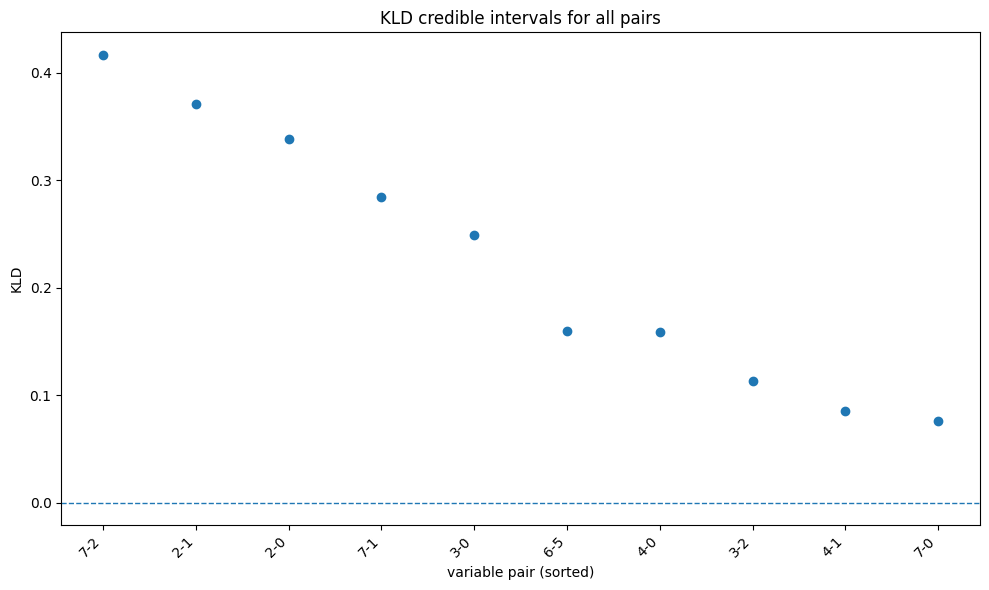

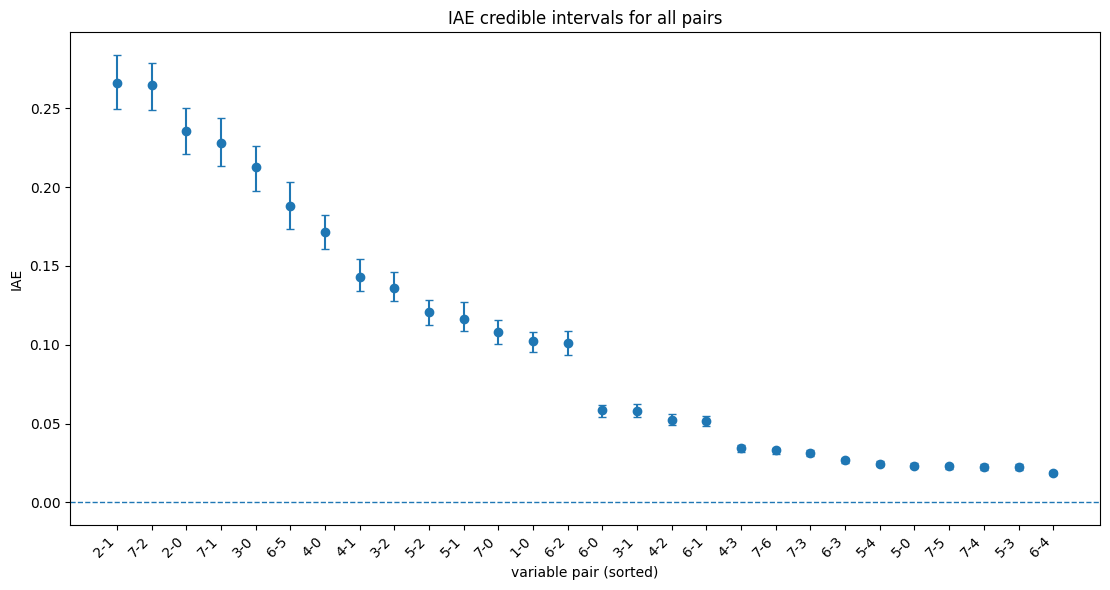

In [45]:
plot_metric_ci(df_ci, metric="kld", log_scale=False, top_n=10)
plot_metric_ci(df_ci, metric="iae", log_scale=False)


In [24]:
#CI_groups = theta_ci_by_group(VI, level=0.95, sort_within_group=True)

#if CI_groups["transformation"] is not None:
#    plot_theta_ci_group(CI_groups["transformation"], "Transformation", max_params=200)

#if CI_groups["decorrelation"] is not None:
#    plot_theta_ci_group(CI_groups["decorrelation"], "Decorrelation", max_params=200)


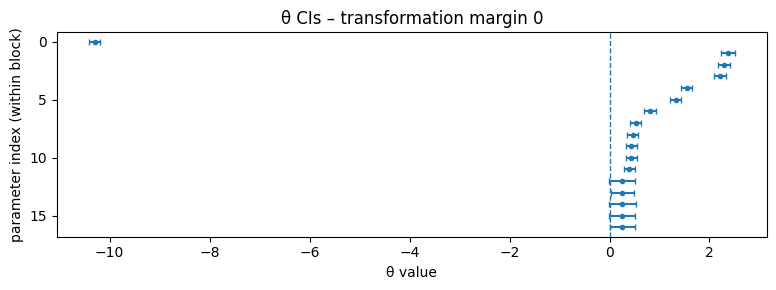

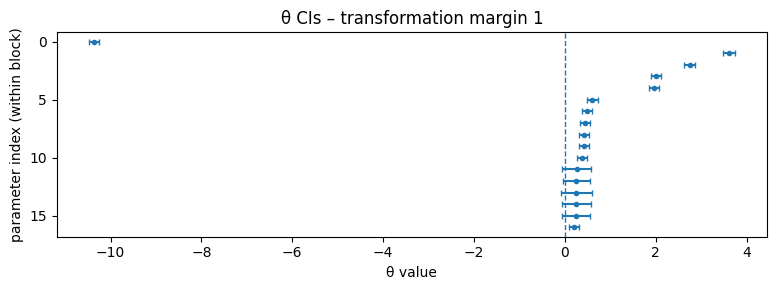

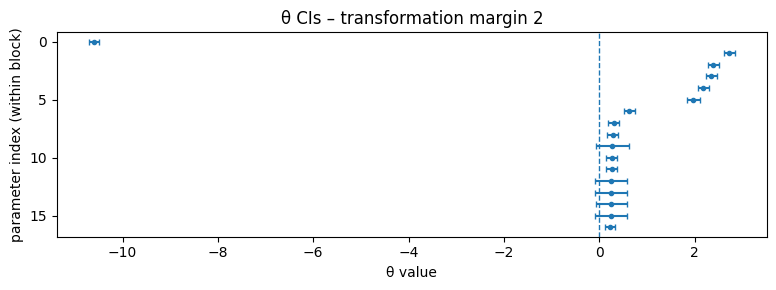

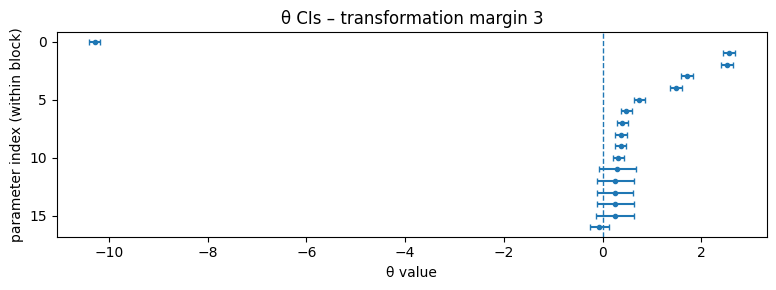

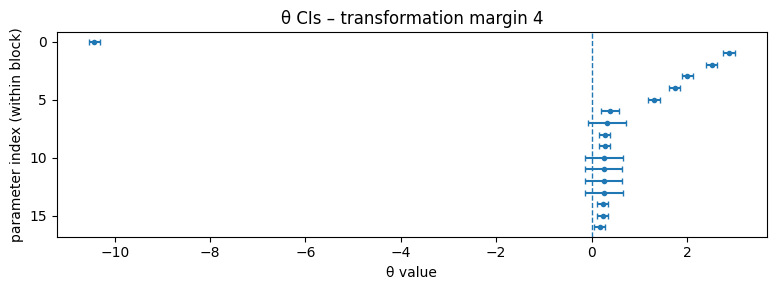

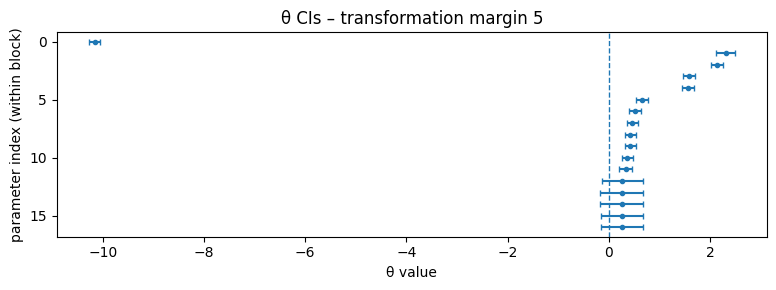

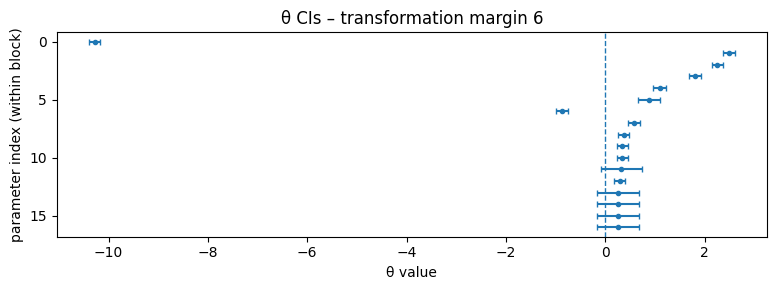

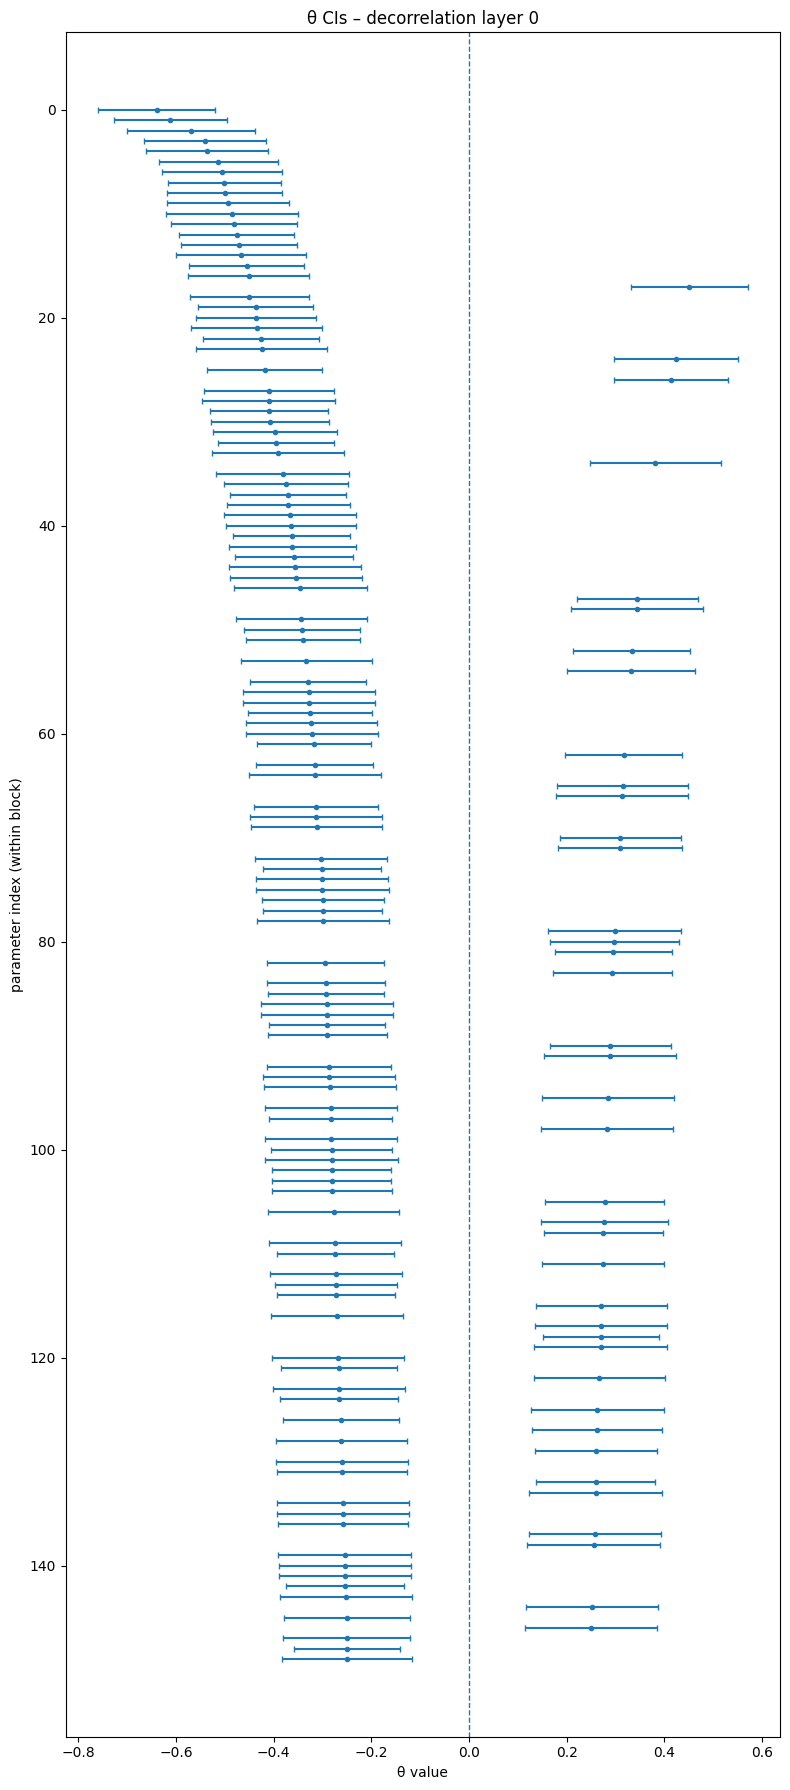

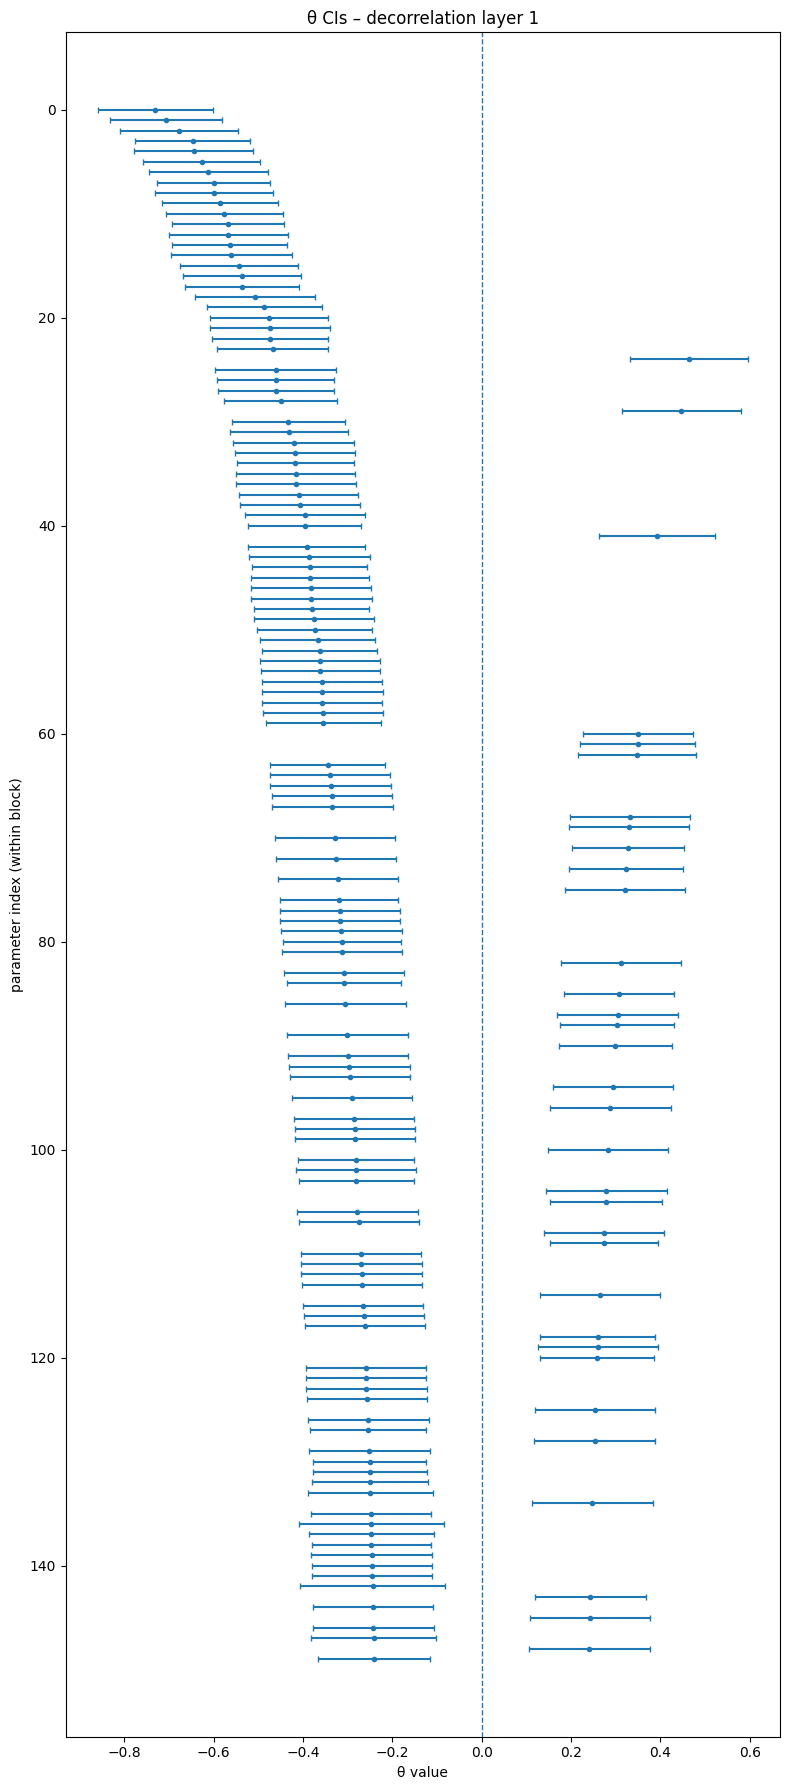

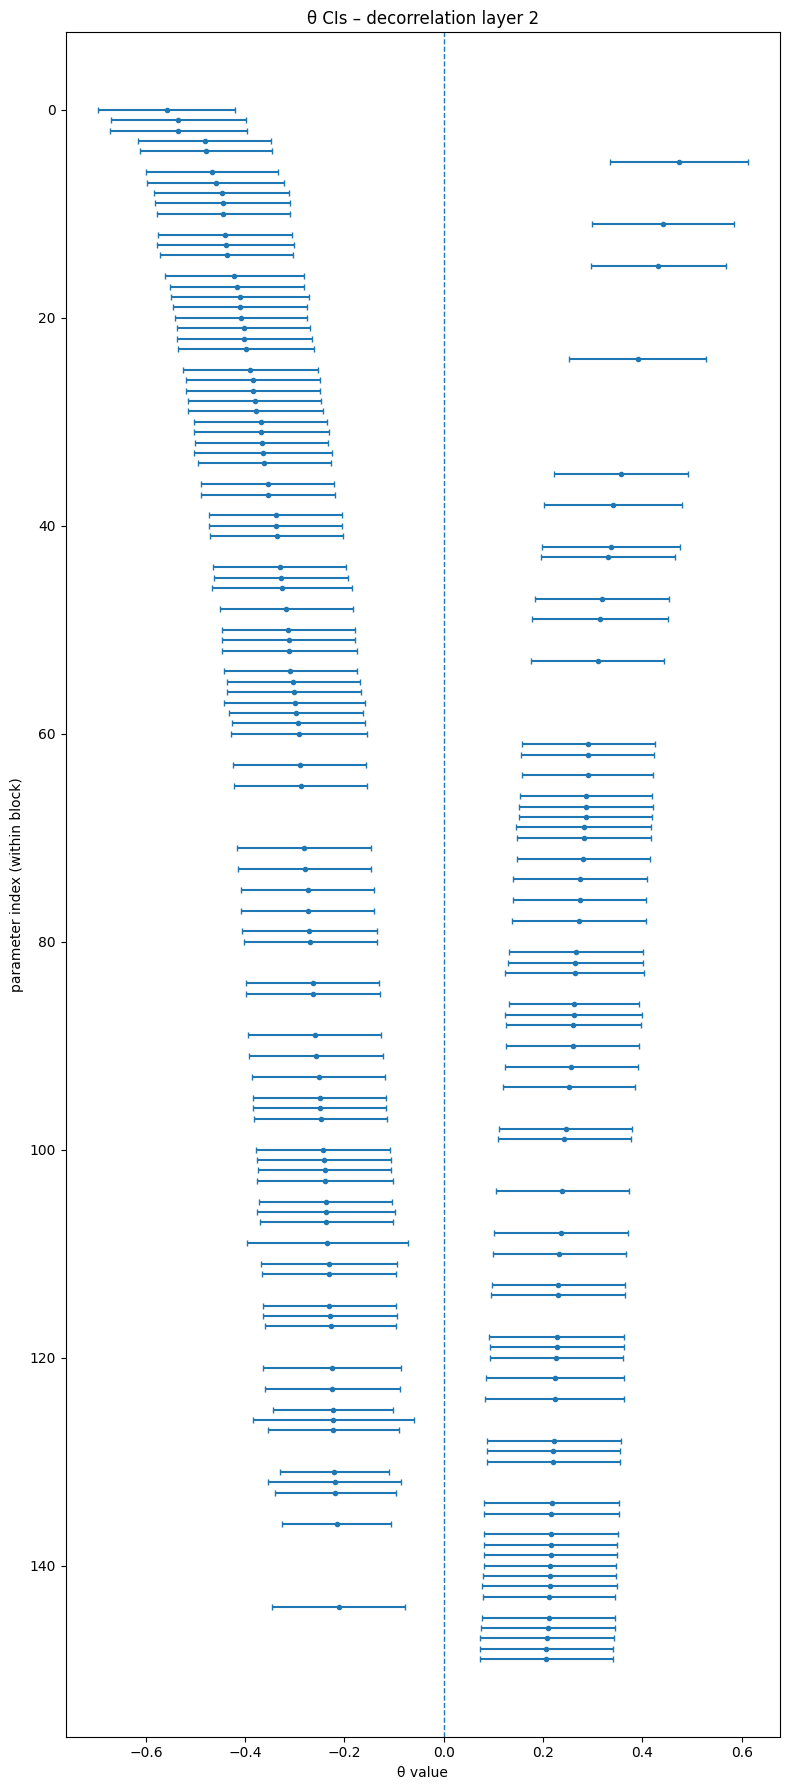

In [25]:
ci_blocks = theta_ci_by_schema(VI, level=0.95, sort_within_group=True)

# Transformation per margin
for j in range(7):
    key = f"transformation.params.{j}"
    plot_theta_ci_block(ci_blocks[key], title=f"θ CIs – transformation margin {j}", max_params=150)

# Decorrelation layers
for ℓ in range(3):
    key = f"decorrelation_layers.{ℓ}.params"
    plot_theta_ci_block(ci_blocks[key], title=f"θ CIs – decorrelation layer {ℓ}", max_params=150)


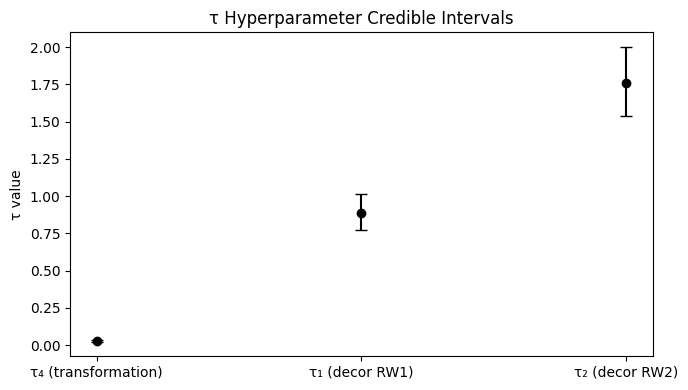

In [26]:
ci_4 = tau_ci_from_node(tau_nodes.node4)
ci_2 = tau_ci_from_node(tau_nodes.node2)
ci_1 = tau_ci_from_node(tau_nodes.node1)

tau_info = [
    ("τ₄ (transformation)", ci_4["mean"], ci_4["lower"], ci_4["upper"]),
]
if True: ### decor_present output from train method
    tau_info += [
        ("τ₁ (decor RW1)", ci_1["mean"], ci_1["lower"], ci_1["upper"]),
        ("τ₂ (decor RW2)", ci_2["mean"], ci_2["lower"], ci_2["upper"]),
    ]
plot_tau_nodes(tau_info)

we plot synthetic samples and overlay the conditional dependence structure for all pairs with strong conditional dependence according to there IAE metric.

In [27]:
synthetic_samples = model.sample(2000)

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_model/gtm.py:1299: UserWarning: Transformation layer does not have an inverse. Inverse is approximated
  warnings.warn(


[FIX] var 0: valid interval = [-9.999999, 9.999999]
[FIX] var 1: valid interval = [-9.999999, 9.999999]
[FIX] var 2: valid interval = [-9.999999, 9.999999]
[FIX] var 3: valid interval = [-9.999999, 9.999999]
[FIX] var 4: valid interval = [-9.999999, 9.999999]
[FIX] var 5: valid interval = [-9.999999, 9.999999]
[FIX] var 6: valid interval = [-9.999999, 9.999999]
[FIX] var 7: valid interval = [-9.999999, 9.999999]


/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


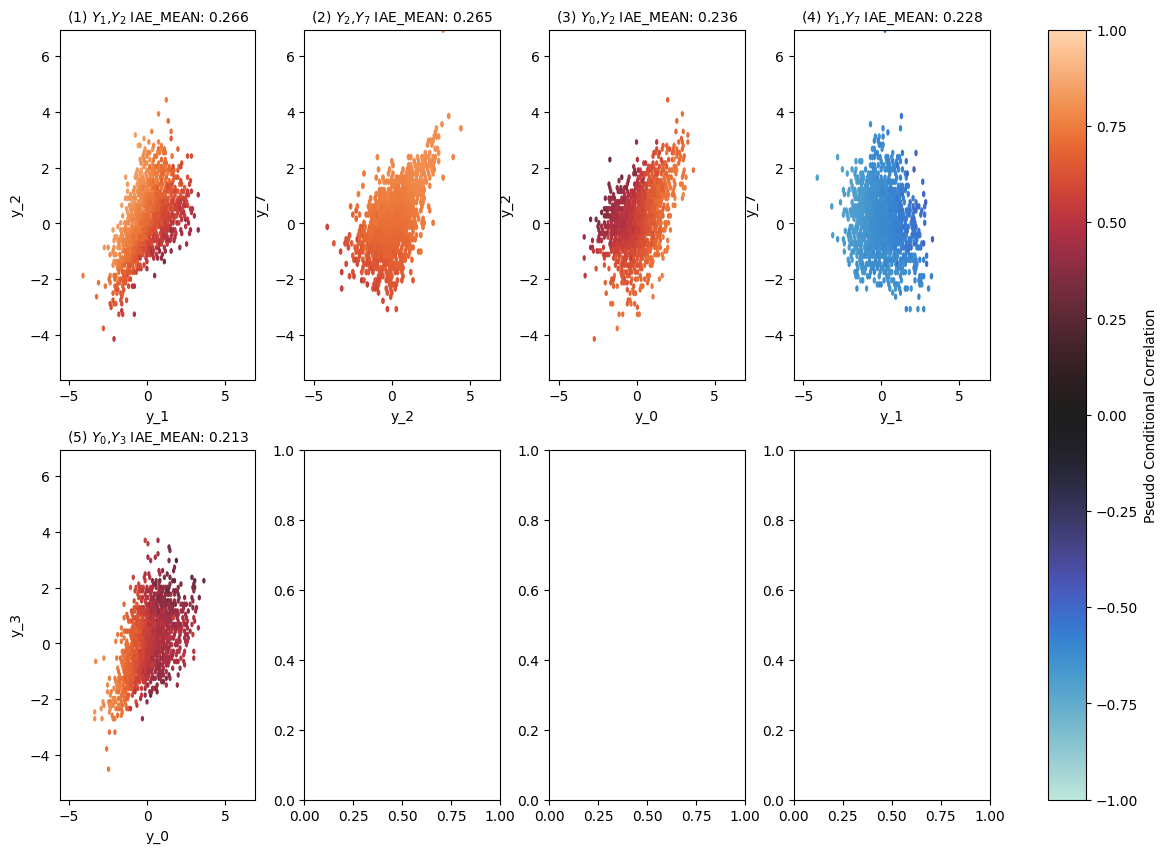

In [28]:
model.plot_conditional_dependence_structure(data=synthetic_samples,
                          dependence_metric_threshholding="iae_mean",
                          minimum_dependence_threshold=0.2, 
                          )

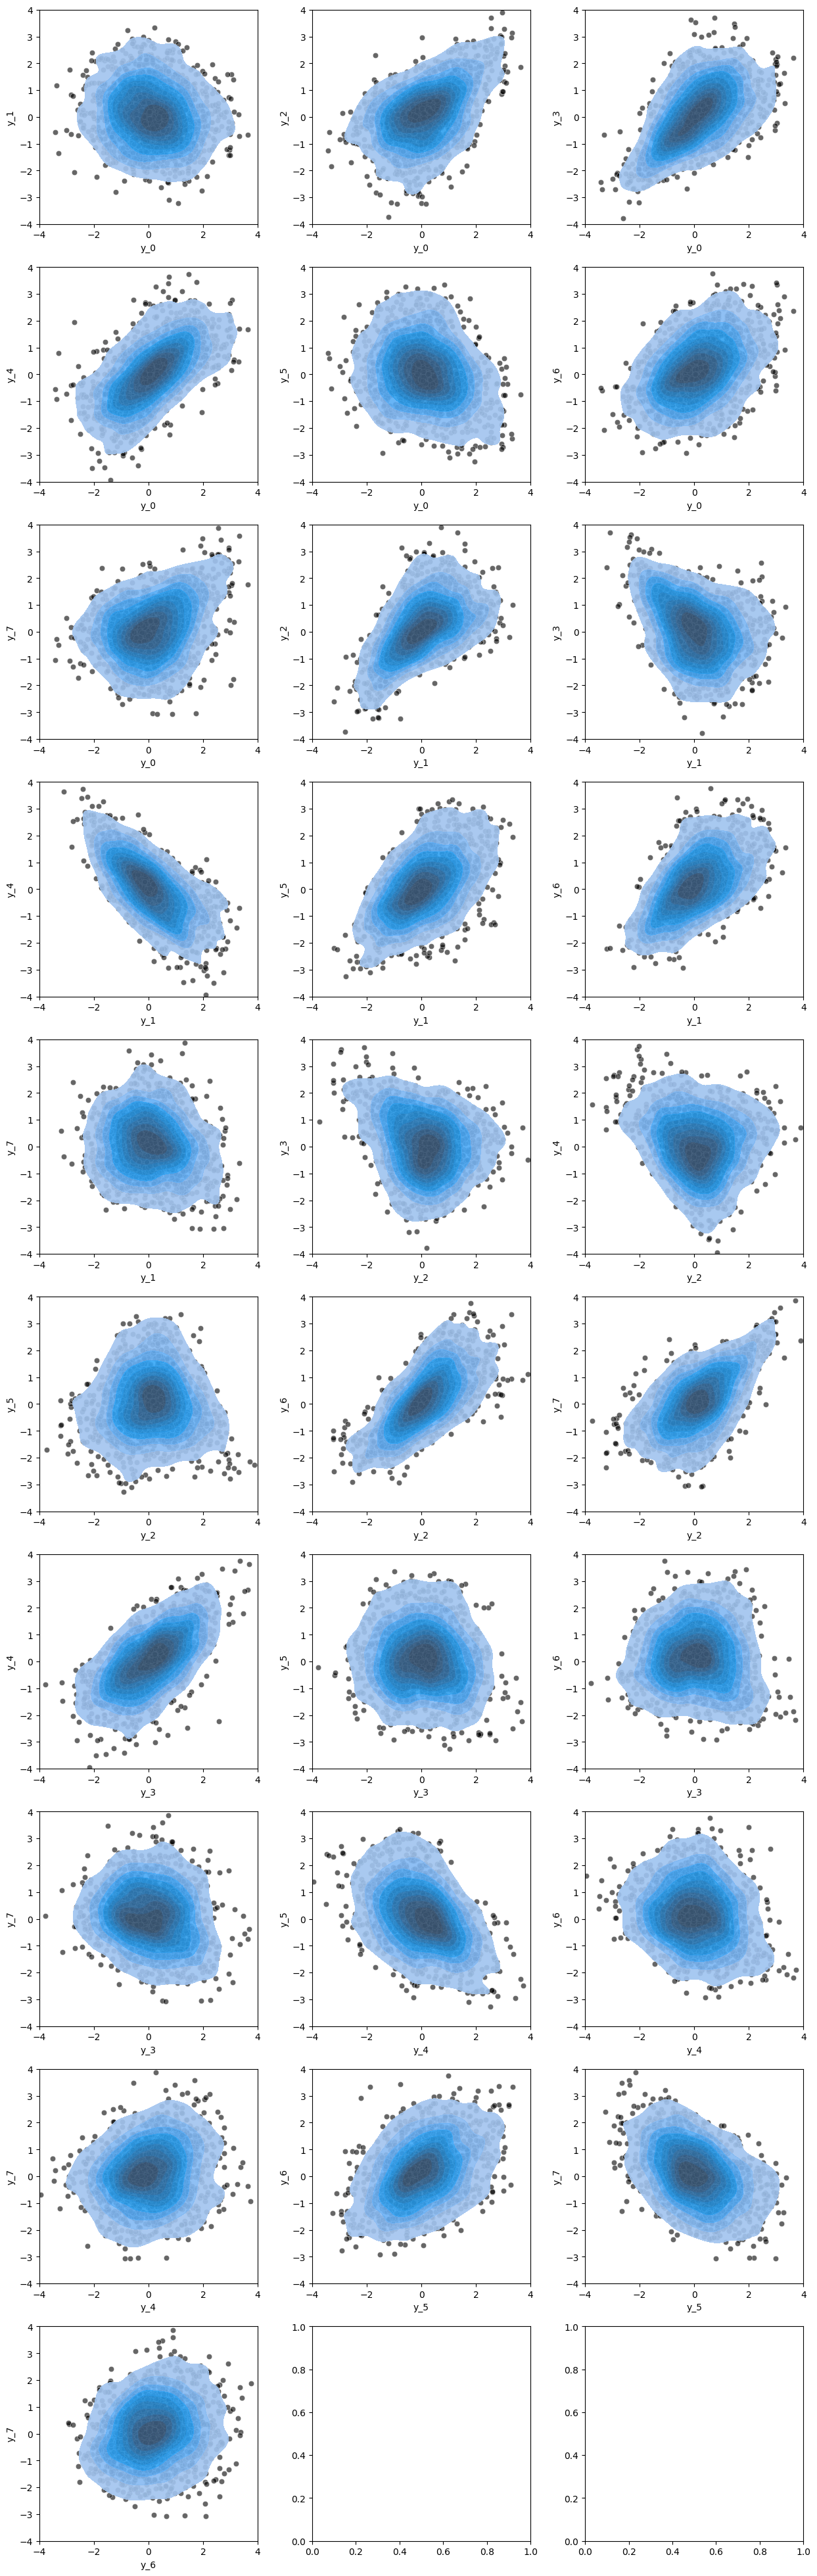

In [29]:
model.plot_densities(synthetic_samples.cpu(), x_lim=[-4,4], y_lim=[-4,4])

The splines of the model, 10 transformation layer splines and 3 x 45 decorrelation layer splines can also be plotted.

In [30]:
#model.plot_splines(layer_type="transformation")

In [31]:
#model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=0)

In [32]:
#model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=1)

In [33]:
#model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=2)

### 6. Identifying the Conditional Independence Graph

We compare the true known conditional independence Graph to the one learned by the GTM. To do so we first merge the true structure table with our learned one.

In [34]:
merged_ci_tables = pd.merge(
    conditional_independence_table,
    df_true_structure_sub,
    on=["var_row", "var_col"]
)


take a look at the table and sort by some idicator such as iae.

In [35]:
#merged_ci_tables.sort_values("iae",ascending=False) 

with the spearman and pearson correlations one can see how similar the metrics are and how strongly correlated they are to the dependence.

In [36]:
merged_ci_tables.corr("spearman") #"pearson"

,index,var_row,var_col,abs_mean,mean,std,min,q_1,q_5,q_10,...,cond_correlation_abs_lo,cond_correlation_abs_hi,cond_correlation_square_mean,kld_mean,kld_lo,kld_hi,iae_mean,iae_lo,iae_hi,dependence
index,1.000000,0.982607,0.619978,-0.439518,0.141762,-0.519431,0.233169,0.198139,0.179529,0.176245,...,-0.347564,-0.318555,-0.335523,-0.363437,-0.363437,-0.363437,-0.402846,-0.409414,-0.406130,-0.367909
var_row,0.982607,1.000000,0.470238,-0.365693,0.123661,-0.456489,0.213901,0.180479,0.166553,0.161540,...,-0.282695,-0.256793,-0.271275,-0.296899,-0.296899,-0.296899,-0.339791,-0.346475,-0.344247,-0.333821
var_col,0.619978,0.470238,1.000000,-0.577365,0.179922,-0.597419,0.227270,0.204988,0.181871,0.189113,...,-0.489076,-0.464009,-0.475985,-0.524447,-0.524447,-0.524447,-0.514699,-0.516649,-0.506344,-0.360888
abs_mean,-0.439518,-0.365693,-0.577365,1.000000,-0.273125,0.856048,-0.328407,-0.309797,-0.314176,-0.311440,...,0.961138,0.970443,0.974275,0.927750,0.927750,0.927750,0.973180,0.973727,0.972633,0.695924
mean,0.141762,0.123661,0.179922,-0.273125,1.000000,-0.267652,0.936508,0.951834,0.956760,0.962781,...,-0.277504,-0.303229,-0.306513,-0.291188,-0.291188,-0.291188,-0.278599,-0.279693,-0.288451,-0.367909
std,-0.519431,-0.456489,-0.597419,0.856048,-0.267652,1.000000,-0.380405,-0.347564,-0.353038,-0.346470,...,0.825944,0.822660,0.837986,0.803503,0.803503,0.803503,0.846196,0.846743,0.845101,0.820038
min,0.233169,0.213901,0.227270,-0.328407,0.936508,-0.380405,1.000000,0.992885,0.987958,0.983580,...,-0.331691,-0.338259,-0.357964,-0.299398,-0.299398,-0.299398,-0.348659,-0.350848,-0.359059,-0.421101
q_1,0.198139,0.180479,0.204988,-0.309797,0.951834,-0.347564,0.992885,1.000000,0.995621,0.991790,...,-0.318555,-0.320744,-0.340449,-0.275315,-0.275315,-0.275315,-0.328407,-0.330049,-0.338259,-0.376774
q_5,0.179529,0.166553,0.181871,-0.314176,0.956760,-0.353038,0.987958,0.995621,1.000000,0.998358,...,-0.319102,-0.329502,-0.347017,-0.274220,-0.274220,-0.274220,-0.329502,-0.331144,-0.340449,-0.376774
q_10,0.176245,0.161540,0.189113,-0.311440,0.962781,-0.346470,0.983580,0.991790,0.998358,1.000000,...,-0.313629,-0.326765,-0.341544,-0.275862,-0.275862,-0.275862,-0.324576,-0.326218,-0.335523,-0.376774


however the proper metric as identifying full conditional independence is a classification task is the AUC (Area under the ROC-Curve).

In [37]:
auc_iae = roc_auc_score(merged_ci_tables["dependence"], merged_ci_tables["iae_mean"])
auc_kld = roc_auc_score(merged_ci_tables["dependence"], merged_ci_tables["kld_mean"])
auc_corr = roc_auc_score(merged_ci_tables["dependence"], merged_ci_tables["cond_correlation_abs_mean"])
auc_pmat = roc_auc_score(merged_ci_tables["dependence"], merged_ci_tables["precision_abs_mean"])
print("AUC IAE                    :",auc_iae)
print("AUC KLD                    :",auc_kld)
print("AUC Conditional Correlation:",auc_corr)
print("AUC Precision Matrix       :",auc_pmat)

AUC IAE                    : 0.9025641025641027
AUC KLD                    : 0.9230769230769231
AUC Conditional Correlation: 0.9076923076923078
AUC Precision Matrix       : 0.9025641025641027


We further print the ROC Curves for different metrics.

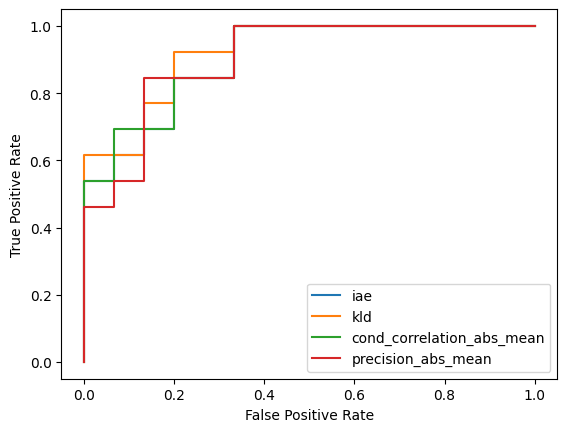

In [38]:
fpr, tpr, thresholds = roc_curve(merged_ci_tables["dependence"], merged_ci_tables["iae_mean"])
plt.plot(fpr, tpr, label="iae")
fpr, tpr, thresholds = roc_curve(merged_ci_tables["dependence"], merged_ci_tables["kld_mean"])
plt.plot(fpr, tpr, label="kld")
fpr, tpr, thresholds = roc_curve(merged_ci_tables["dependence"], merged_ci_tables["cond_correlation_abs_mean"])
plt.plot(fpr, tpr, label="cond_correlation_abs_mean")
fpr, tpr, thresholds = roc_curve(merged_ci_tables["dependence"], merged_ci_tables["precision_abs_mean"])
plt.plot(fpr, tpr, label="precision_abs_mean")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()